![alt text](https://esap.seas.upenn.edu/wp-content/themes/summer_engineering/media/seas_logo.png)

#Introduction

Welcome to our course project for CIS-5450 (Big Data Analytics)!

Our team consists of:

*   Ryan Abbate (MSE-DS, inaugural cohort)
*   Paul Hamel (MCIT, Spring 2022 cohort)
*   Milan Mistry (MCIT, Fall 2021 cohort)

<br>
For this project, we built machine learning models that predict a borrower's propensity to default on a loan. Throughout this notebook, we walk through our end-to-end process, which included:

* data ingestion
* exploratory data analysis (EDA)
* data wrangling
* data cleaning
* machine learning modeling
* data visualization


# Motivation

Individuals with insufficient or non-existent credit histories often encounter challenges in securing loans.  Those fortunate enough to obtain loans may fall victim to unscrupulous lenders who impose exorbitant interest rates and unfavorable lending terms.

Lenders generally aim to optimize profits while minimizing potential risks.  Lenders that use *accurate* predictive models when assessing default risk among certain customer profiles are able to extend credit to borrowers who may not meet traditional lending standards.  This data-driven approach ensures that borrowers who are capable of loan repayment receive the capital that they need, which has a stimulative effect on economic activity.


# Data Source

For this project, we used loan repayment data from a Kaggle competition hosted by [Home Credit Group](https://www.homecredit.net/) in 2018.  Details about the competition may be found [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The data consists of nine (9) csv files totaling approximately 3GB in size.  

# Data Ingestion

To retrieve and ingest the data from Kaggle's public API, users must authenticate with an API token.  To create an API token, please follow the instructions outlined [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The API token will be in the form of a JSON file named `kaggle.json`.  

#Dependencies

Let's begin by installing the required dependencies.


In [ ]:
# install dependencies with silenced output
!pip install kaggle --quiet
!pip install tqdm --quiet

Next, we import the Python libraries that we'll use for this project.

In [ ]:
# import the required libraries

# general
from google.colab import drive
from tqdm.notebook import tqdm
import os


# data wrangling, cleaning and sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# model selection
from sklearn.model_selection import train_test_split

# models
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier

# model tuning
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# visualization
from matplotlib import colors
from matplotlib import lines
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import seaborn as sns


In [ ]:
# Graph Settings

mpl.rcParams['figure.figsize'] = [12,6]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.labelweight'] = 'normal'
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['font.family'] = 'Sans'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.color'] = 'lightgrey'
mpl.rcParams['xtick.color'] = 'lightgrey'
mpl.rcParams['text.color'] = 'lightgrey'
mpl.rcParams['axes.titlecolor'] = 'lightgrey'
mpl.rcParams['axes.labelcolor'] = 'lightgrey'
mpl.rcParams['axes.edgecolor'] = 'lightgrey'

mpl.rcParams['date.autoformatter.year'] = '%Y'
mpl.rcParams['date.autoformatter.month'] = '%b-%Y'
#change background color to transparent
mpl.rcParams['figure.facecolor'] = '#282c34'
#change plot foreground color to grey
mpl.rcParams['axes.facecolor'] = '#282c34'

#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#00396f", "#a12830", '#00ab39',"#ffe312",'#c41e98','#008000','#ff5e00','#00a6d4','#6c1b72'])
#change default color cycler to ggplot
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D'])
mpl.rcParams['lines.linewidth'] = 2
colors = ['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D']
#colors = ["#00396f", "#a12830", '#00ab39',"#ffe312",'#c41e98','#008000','#ff5e00','#00a6d4','#6c1b72']

Run the cell below, then click "Choose Files".  Browse to the `kaggle.json` file, then select this file for upload.

In [ ]:
# # upload your Kaggle API key to download the data
# from google.colab import files
# files.upload()


Next, we'll create a Kaggle directory and copy the file containing our API token into the newly created directory.

In [ ]:
# # create the Kaggle directory
# !mkdir ~/.kaggle

# # copy the file containing API key to newly created directory and change file permissions
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

We'll now download the dataset in the form of a zip file.

In [ ]:
# # download the dataset
# !!kaggle competitions download -c home-credit-default-risk

After downloading the dataset, we'll unzip the file into our `Content` directory.

In [ ]:
# # unzip the zip file into the Content directory
# !unzip /content/home-credit-default-risk.zip

Now, we'll identify the files that we'll use during our analysis and exclude those that are irrelevant.

In [ ]:
# the list of files to exclude from relevant data files
excluded_files = ['kaggle.json', 'home-credit-default-risk.zip', '.config', 'sample_data', 'sample_submission.csv', 'HomeCredit_columns_description.csv']

# create a list of relevant data files
data_files = [data_file for data_file in os.listdir('/content') if data_file not in excluded_files]
data_files


['previous_application.csv',
 'POS_CASH_balance.csv',
 'installments_payments.csv',
 'credit_card_balance.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'application_train.csv',
 'application_test.csv']

After identifying the relevant eight (8) data files, we'll create a Pandas dataframe for each.  Notice that we create an empty dictionary `d`, then iterate through the list of relevant file and append `_df` to the file name when assigning the name of the dataframe.  We use the popular `tqdm` library to monitor progress as the dataframes are being created.

In [ ]:
# iterate over list of relevant data files and create a Pandas dataframe for each

d = {}

for data_file in tqdm(data_files):
  # if 'bureau' in data_file:
  #   continue
  print('Creating:', data_file.removesuffix('.csv') + '_df')
  d[(data_file.removesuffix('.csv') + '_df').lower()] = pd.read_csv(data_file)


  0%|          | 0/8 [00:00<?, ?it/s]

Creating: previous_application_df
Creating: POS_CASH_balance_df
Creating: installments_payments_df
Creating: credit_card_balance_df
Creating: bureau_df
Creating: bureau_balance_df
Creating: application_train_df
Creating: application_test_df


In [ ]:
# # #For Paul when running locally -- ignore this
# d = {}
# d['application_test_df'] = pd.read_csv('./data/application_test.csv', encoding='latin-1')
# d['application_train_df'] = pd.read_csv('./data/application_train.csv', encoding='latin-1')
# d['bureau_df'] = pd.read_csv('./data/bureau.csv', encoding='latin-1')
# d['bureau_balance_df'] = pd.read_csv('./data/bureau_balance.csv', encoding='latin-1')
# d['credit_card_balance_df'] = pd.read_csv('./data/credit_card_balance.csv', encoding='latin-1')
# d['installments_payments_df'] = pd.read_csv('./data/installments_payments.csv', encoding='latin-1')
# d['pos_cash_balance_df'] = pd.read_csv('./data/POS_CASH_balance.csv', encoding='latin-1')
# d['previous_application_df'] = pd.read_csv('./data/previous_application.csv', encoding='latin-1')

Since we stored the dataframes in a dictionary `d`, we access a given dataframe by its key.  Let's inspect the data.

In [ ]:
# access dataframes via a dictionary such as d['application_train_df']
d['application_train_df'].head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# inspect all dataframes
for key, df in d.items():
  print(key)
  print('\n')
  print(df.head())
  print('\n')


previous_application_df


   SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ..

In [ ]:
# cast all column headers to lowercase
for key, df in d.items():
  df.columns = df.columns.str.lower()


#Exploratory Data Analysis (EDA)

We start by exploring the basic characteristics of the various datasets.  For each dataframe, we call the `info()` method to display the data type and non-null counts.  We also call the `describe()` method to display the summary statistics.

In [ ]:
for key, df in d.items():
  print(key)
  df.info(verbose = True, show_counts = True)
  print('-' * 72)

previous_application_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   sk_id_prev                   1670214 non-null  int64  
 1   sk_id_curr                   1670214 non-null  int64  
 2   name_contract_type           1670214 non-null  object 
 3   amt_annuity                  1297979 non-null  float64
 4   amt_application              1670214 non-null  float64
 5   amt_credit                   1670213 non-null  float64
 6   amt_down_payment             774370 non-null   float64
 7   amt_goods_price              1284699 non-null  float64
 8   weekday_appr_process_start   1670214 non-null  object 
 9   hour_appr_process_start      1670214 non-null  int64  
 10  flag_last_appl_per_contract  1670214 non-null  object 
 11  nflag_last_appl_in_day       1670214 non-null  int64  
 12  rate_down_payment 

For each dataframe, let's check the percent of missing values for each attribute.

In [ ]:
for key, df in d.items():
  print(key)
  percent_missing = df.isnull().sum() * 100 / len(df)
  missing_values_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing}) \
                                .sort_values(by = ['percent_missing'], ascending = False).round(2)
  print(missing_values_df)
  print('-' * 72)




previous_application_df
                                             column_name  percent_missing
rate_interest_privileged        rate_interest_privileged            99.64
rate_interest_primary              rate_interest_primary            99.64
amt_down_payment                        amt_down_payment            53.64
rate_down_payment                      rate_down_payment            53.64
name_type_suite                          name_type_suite            49.12
nflag_insured_on_approval      nflag_insured_on_approval            40.30
days_termination                        days_termination            40.30
days_last_due                              days_last_due            40.30
days_last_due_1st_version      days_last_due_1st_version            40.30
days_first_due                            days_first_due            40.30
days_first_drawing                    days_first_drawing            40.30
amt_goods_price                          amt_goods_price            23.08
amt_annuity   

We immediately notice that there is a **large** amount of missing data.

We notice the prevalance of the `sk_id_curr` attribute, which is the primary key of the `application_{test | train}_df` relations.  The following relations have `sk_id_curr` as a foreign key:

*   `bureau_df`
*   `pos_cash_balance_df`
*   `previous_application_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

We will join the `application_{test | train}_df` relations to each of the five (5) above-mentioned relations.

We also notice the prevalance of the `sk_id_prev` attribute, which is the primary key of the `previous_application_df` relation.  The following relations have `sk_id_prev` as a foreign key:

*   `pos_cash_balance_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

Lastly, we notice that the `sk_id_bureau` attribute is the primary key of the `bureau_df` relation.  The `bureau_balance_df` relation has `sk_id_bureau` as a foreign key.  We will therefore join these two relations together.


First, we explore what % of the unique `sk_id_prev` IDs are within each dataset. We see that most of the datasets have a high representation of the IDs present. The two datasets with low representation are the `bureau_balance_df` and the `credit_card_balance_df` dataframes. We will later explore whether adding features from these two datasets are better when having a dummy variable for whether each feature is valid, or whether multiple models depending on the availability of data is more suitable for this dataset.

In [ ]:
train_ids = d['application_train_df']['sk_id_curr'].unique()

# Bureau
# bureau_pct = len(np.intersect1d(d['bureau_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
# print('Bureau: {:.2%}'.format(bureau_pct))

# # Bureau Balance
# valid_bureau_ids = np.intersect1d(d['bureau_balance_df']['sk_id_bureau'].unique(), d['bureau_df']['sk_id_bureau'].unique())
# buearu_balance_pct = len(np.intersect1d(d['bureau_df'].loc[d['bureau_df']['sk_id_bureau'].isin(valid_bureau_ids),'sk_id_curr'].unique(),train_ids)) / len(train_ids)
# print('Bureau Balance: {:.2%}'.format(buearu_balance_pct))

# Credit Card Balance
cc_pct = len(np.intersect1d(d['credit_card_balance_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
print('Credit Card Balance: {:.2%}'.format(cc_pct))

# Previous Application
prev_app_pct = len(np.intersect1d(d['previous_application_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Previous Application: {:.2%}'.format(prev_app_pct))

# POS Cash Balance
pos_cash_pct = len(np.intersect1d(d['pos_cash_balance_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('POS Cash Balance: {:.2%}'.format(pos_cash_pct))

# Installments Payments
installments_pct = len(np.intersect1d(d['installments_payments_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Installments Payments: {:.2%}'.format(installments_pct))


Credit Card Balance: 28.26%
Previous Application: 94.65%
POS Cash Balance: 94.12%
Installments Payments: 94.84%


Let's check for duplication.

In [ ]:
for key, df in d.items():
  print('Dataframe:', key)
  print(df.nunique())
  print('-' * 72)

Dataframe: previous_application_df
sk_id_prev                     1670214
sk_id_curr                      338857
name_contract_type                   4
amt_annuity                     357959
amt_application                  93885
amt_credit                       86803
amt_down_payment                 29278
amt_goods_price                  93885
weekday_appr_process_start           7
hour_appr_process_start             24
flag_last_appl_per_contract          2
nflag_last_appl_in_day               2
rate_down_payment               207033
rate_interest_primary              148
rate_interest_privileged            25
name_cash_loan_purpose              25
name_contract_status                 4
days_decision                     2922
name_payment_type                    4
code_reject_reason                   9
name_type_suite                      7
name_client_type                     4
name_goods_category                 28
name_portfolio                       5
name_product_type            

In [ ]:
# get summary statistics of each dataset

for key, df in d.items():
  print(key)
  print(df.describe(include = np.number).T)
  print('-' * 72)

previous_application_df
                               count          mean            std  \
sk_id_prev                 1670214.0  1.923089e+06  532597.958696   
sk_id_curr                 1670214.0  2.783572e+05  102814.823849   
amt_annuity                1297979.0  1.595512e+04   14782.137335   
amt_application            1670214.0  1.752339e+05  292779.762386   
amt_credit                 1670213.0  1.961140e+05  318574.616547   
amt_down_payment            774370.0  6.697402e+03   20921.495410   
amt_goods_price            1284699.0  2.278473e+05  315396.557937   
hour_appr_process_start    1670214.0  1.248418e+01       3.334028   
nflag_last_appl_in_day     1670214.0  9.964675e-01       0.059330   
rate_down_payment           774370.0  7.963682e-02       0.107823   
rate_interest_primary         5951.0  1.883569e-01       0.087671   
rate_interest_privileged      5951.0  7.735025e-01       0.100879   
days_decision              1670214.0 -8.806797e+02     779.099667   
sellerplac

## Distrubtion of Response Variable

- The training data consists primarily of loans that have not defaulted.  Therefore, in a later step, we must oversample or undersample to compensate for this unbalanced data.

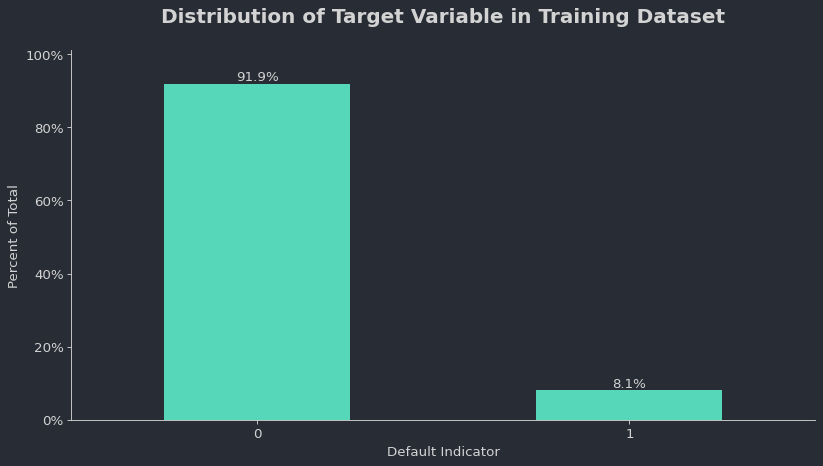

In [ ]:
# plot the distribution of the Response Variable in the training dataset
# will need to do some form of undersampling or oversampling to deal with the class imbalance

ax = (d['application_train_df']['target'].value_counts() * 100/len(d['application_train_df'])).plot(kind = 'bar')

plt.title('Distribution of Target Variable in Training Dataset')
plt.xlabel('Default Indicator')
plt.ylabel('Percent of Total')
plt.xticks(rotation = 'horizontal')

ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.1f%%')
ax.margins(y = 0.1)

#make y axis percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

The training dataset has highly unbalanced classes, which could affect our modeling.

#Correlation Analysis
Now, we'll generate a correlation matrix on the training dataset to check for correlation among the features.

In [ ]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

corr = d['application_train_df'].corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm').format(precision = 2)


Given the size of this correlation matrix, let's set a threshold and view only the features that have correlation greater than a certain threshold.

In [ ]:
# define a threshold
correlation_threshold = 0.7

# get a list of pair-wise features that exceed this threshold
high_correlation_pairs = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > correlation_threshold:
            high_correlation_pairs.append((corr.columns[i], corr.columns[j]))


high_correlation_pairs


[('cnt_children', 'cnt_fam_members'),
 ('amt_credit', 'amt_annuity'),
 ('amt_credit', 'amt_goods_price'),
 ('amt_annuity', 'amt_goods_price'),
 ('days_employed', 'flag_emp_phone'),
 ('region_rating_client', 'region_rating_client_w_city'),
 ('reg_region_not_work_region', 'live_region_not_work_region'),
 ('reg_city_not_work_city', 'live_city_not_work_city'),
 ('apartments_avg', 'elevators_avg'),
 ('apartments_avg', 'livingapartments_avg'),
 ('apartments_avg', 'livingarea_avg'),
 ('apartments_avg', 'apartments_mode'),
 ('apartments_avg', 'elevators_mode'),
 ('apartments_avg', 'livingapartments_mode'),
 ('apartments_avg', 'livingarea_mode'),
 ('apartments_avg', 'apartments_medi'),
 ('apartments_avg', 'elevators_medi'),
 ('apartments_avg', 'livingapartments_medi'),
 ('apartments_avg', 'livingarea_medi'),
 ('apartments_avg', 'totalarea_mode'),
 ('basementarea_avg', 'basementarea_mode'),
 ('basementarea_avg', 'basementarea_medi'),
 ('years_beginexpluatation_avg', 'years_beginexpluatation_mode

In [ ]:
print(f'There are {len(high_correlation_pairs)} that exhibit correlation greater than {correlation_threshold}.')

There are 127 that exhibit correlation greater than 0.7.


In [ ]:
# create a heatmap of only the high correlation pairs

high_correlation_features = set()

for pair in high_correlation_pairs:
  high_correlation_features.update(pair)

high_correlation_matrix = corr.loc[high_correlation_features, high_correlation_features]
high_correlation_matrix

high_correlation_matrix.style.background_gradient(cmap = 'coolwarm').format(precision = 2)



<ipython-input-23-232ef2997238>:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  high_correlation_matrix = corr.loc[high_correlation_features, high_correlation_features]


,nonlivingapartments_avg,floorsmax_avg,commonarea_avg,basementarea_mode,livingapartments_medi,commonarea_medi,live_region_not_work_region,years_build_mode,reg_region_not_work_region,amt_annuity,livingapartments_mode,livingarea_mode,basementarea_avg,floorsmax_medi,elevators_medi,basementarea_medi,years_build_medi,days_employed,floorsmax_mode,floorsmin_mode,livingarea_avg,flag_emp_phone,livingarea_medi,years_beginexpluatation_medi,def_30_cnt_social_circle,region_rating_client,entrances_avg,years_beginexpluatation_mode,landarea_medi,nonlivingarea_avg,livingapartments_avg,entrances_medi,landarea_avg,elevators_avg,nonlivingapartments_mode,nonlivingarea_mode,obs_30_cnt_social_circle,commonarea_mode,cnt_fam_members,cnt_children,live_city_not_work_city,floorsmin_medi,nonlivingapartments_medi,region_rating_client_w_city,apartments_avg,apartments_medi,obs_60_cnt_social_circle,def_60_cnt_social_circle,floorsmin_avg,nonlivingarea_medi,apartments_mode,reg_city_not_work_city,amt_goods_price,years_beginexpluatation_avg,amt_credit,years_build_avg,entrances_mode,totalarea_mode,landarea_mode,elevators_mode
nonlivingapartments_avg,1.00,0.11,0.11,0.09,0.16,0.11,0.01,0.07,0.00,0.02,0.14,0.13,0.10,0.11,0.12,0.09,0.07,-0.00,0.11,0.07,0.14,0.00,0.13,0.03,0.00,-0.02,0.06,0.02,0.07,0.22,0.16,0.06,0.07,0.12,0.97,0.21,-0.00,0.10,0.00,0.00,0.00,0.08,0.99,-0.02,0.19,0.19,-0.00,0.00,0.08,0.22,0.18,-0.00,0.02,0.03,0.01,0.07,0.05,0.14,0.06,0.11
floorsmax_avg,0.11,1.00,0.40,0.30,0.59,0.40,0.04,0.51,0.03,0.13,0.57,0.60,0.33,1.00,0.68,0.33,0.52,-0.02,0.99,0.72,0.63,0.02,0.63,0.13,-0.03,-0.23,0.09,0.10,0.22,0.25,0.59,0.08,0.22,0.68,0.10,0.23,-0.04,0.38,-0.00,-0.01,-0.09,0.74,0.11,-0.25,0.62,0.62,-0.04,-0.03,0.74,0.25,0.59,-0.12,0.11,0.13,0.10,0.52,0.06,0.63,0.20,0.66
commonarea_avg,0.11,0.40,1.00,0.39,0.53,1.00,0.03,0.23,0.02,0.06,0.53,0.52,0.41,0.40,0.52,0.40,0.23,-0.01,0.40,0.29,0.55,0.01,0.55,0.07,-0.01,-0.12,0.33,0.05,0.26,0.23,0.53,0.32,0.26,0.52,0.10,0.22,-0.02,0.98,0.00,0.00,-0.03,0.29,0.11,-0.13,0.54,0.54,-0.02,-0.01,0.30,0.23,0.52,-0.03,0.05,0.09,0.05,0.23,0.30,0.55,0.24,0.51
basementarea_mode,0.09,0.30,0.39,1.00,0.63,0.39,0.00,0.24,-0.00,0.03,0.65,0.69,0.97,0.30,0.54,0.98,0.23,-0.00,0.31,0.21,0.67,0.00,0.67,0.07,-0.01,-0.03,0.65,0.06,0.48,0.26,0.62,0.65,0.47,0.54,0.10,0.27,-0.01,0.41,-0.00,-0.01,-0.04,0.20,0.09,-0.05,0.66,0.66,-0.01,-0.01,0.20,0.26,0.68,-0.05,0.04,0.08,0.03,0.23,0.65,0.65,0.48,0.55
livingapartments_medi,0.16,0.59,0.53,0.63,1.00,0.54,0.02,0.33,0.01,0.07,0.98,0.86,0.65,0.59,0.81,0.65,0.33,-0.02,0.58,0.43,0.88,0.02,0.88,0.12,-0.01,-0.15,0.57,0.08,0.43,0.29,0.99,0.57,0.42,0.81,0.15,0.28,-0.03,0.53,-0.01,-0.01,-0.06,0.44,0.16,-0.18,0.94,0.94,-0.03,-0.02,0.44,0.29,0.91,-0.07,0.06,0.15,0.06,0.33,0.54,0.85,0.42,0.80
commonarea_medi,0.11,0.40,1.00,0.39,0.54,1.00,0.03,0.23,0.02,0.06,0.53,0.53,0.41,0.40,0.52,0.41,0.23,-0.01,0.40,0.29,0.55,0.01,0.55,0.07,-0.01,-0.12,0.33,0.05,0.26,0.23,0.53,0.33,0.26,0.52,0.10,0.22,-0.02,0.98,0.00,0.00,-0.03,0.29,0.11,-0.13,0.54,0.54,-0.02,-0.01,0.29,0.23,0.52,-0.03,0.05,0.09,0.05,0.23,0.30,0.55,0.25,0.51
live_region_not_work_region,0.01,0.04,0.03,0.00,0.02,0.03,1.00,0.02,0.86,0.07,0.02,0.02,0.00,0.04,0.03,0.00,0.02,-0.10,0.04,0.05,0.02,0.10,0.02,0.01,-0.02,-0.15,-0.01,0.01,-0.01,0.02,0.02,-0.01,-0.01,0.03,0.01,0.01,-0.02,0.03,0.01,0.01,0.24,0.05,0.01,-0.14,0.02,0.02,-0.02,-0.02,0.05,0.02,0.02,0.19,0.05,0.01,0.05,0.02,-0.01,0.03,-0.01,0.03
years_build_mode,0.07,0.51,0.23,0.24,0.33,0.23,0.02,1.00,0.02,0.03,0.33,0.35,0.25,0.51,0.34,0.25,0.99,-0.01,0.51,0.35,0.35,0.01,0.35,0.42,-0.01,0.05,0.10,0.29,0.19,0.13,0.33,0.09,0.18,0.34,0.07,0.12,0.00,0.23,0.04,0.03,0.03,0.35,0.07,0.04,0.34,0.34,0.00,-0.01,0.35,0.12,0.33,0.03,0.04,0.48,0.03,0.99,0.09,0.36,0.18,0.34
reg_region_not_work_region,0.00,0.03,0.02,-0.00,0.01,0.02,0.86,0.02,1.00,0.08,0.01,0.01,-0.00,0.03,0.02,-0.00,0.02,-0.11,0.03,0.04,0.01,0.11,0.01,0.01,-0.02,-0.14,-0.01,0.01,-0.01,0.01,0.01,-0.01,-0.01,0.02,0.01,0.01,-0.03,0.02,0.00,0.01,0.20,0.04,0.01,-0.13,0.01,0.

In [ ]:
#pd.options.display.max_rows = 100

## Housing Variables

Many of the highly correlated features are housing variables that have characteristics of their current living situation (characteristics regarding their home or apartment). We will reduce the dimensionality of these features by creating PCA variables on these `housing variables` so that we may use them in our modeling. We will then fit a simple logistic regression to see if there is any predictability of using these outright to see if these variables have any predictability on their own.

Due to the high prevalence of null values in these, we fit the PCA and explore the model with the rows that have no nulls in any of them (~25%), and then fill all missing values with the mean of that respective column before transforming the variables of the main dataframes (train/test).

In [ ]:
housing_variables = [ 'apartments_avg',
                      'basementarea_avg',
                      'years_beginexpluatation_avg',
                      'years_build_avg',
                      'commonarea_avg',
                      'elevators_avg',
                      'entrances_avg',
                      'floorsmax_avg',
                      'floorsmin_avg',
                      'landarea_avg',
                      'livingapartments_avg',
                      'livingarea_avg',
                      'nonlivingapartments_avg',
                      'nonlivingarea_avg',
                      'apartments_mode',
                      'basementarea_mode',
                      'years_beginexpluatation_mode',
                      'years_build_mode',
                      'commonarea_mode',
                      'elevators_mode',
                      'entrances_mode',
                      'floorsmax_mode',
                      'floorsmin_mode',
                      'landarea_mode',
                      'livingapartments_mode',
                      'livingarea_mode',
                      'nonlivingapartments_mode',
                      'nonlivingarea_mode',
                      'apartments_medi',
                      'basementarea_medi',
                      'years_beginexpluatation_medi',
                      'years_build_medi',
                      'commonarea_medi',
                      'elevators_medi',
                      'entrances_medi',
                      'floorsmax_medi',
                      'floorsmin_medi',
                      'landarea_medi',
                      'livingapartments_medi',
                      'livingarea_medi',
                      'nonlivingapartments_medi',
                      'nonlivingarea_medi',
                      'housetype_mode',
                      'totalarea_mode',
                      'wallsmaterial_mode',
                      'emergencystate_mode'
                    ]

In [ ]:
print("Percent of rows with valid data for all housing variables: {:.2%}".format((d['application_train_df'][housing_variables].isna().sum(axis = 1) == 0).astype(int).sum() / len(d['application_train_df'])))


Percent of rows with valid data for all housing variables: 26.49%


Due to the lack of variability for the `emergencystate_mode` and `housetype_mode` features, we will drop them from the dataset.

In [ ]:
d['application_train_df']['housetype_mode'].value_counts()

block of flats      150503
specific housing      1499
terraced house        1212
Name: housetype_mode, dtype: int64

In [ ]:
d['application_train_df']['emergencystate_mode'].value_counts()

No     159428
Yes      2328
Name: emergencystate_mode, dtype: int64

In [ ]:

housing_variables.remove('housetype_mode')
housing_variables.remove('emergencystate_mode')

d['application_train_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)
d['application_test_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)

There are only 2 prevalent `wallsmaterial_mode` values, but they have some differentiation in default rates, so we will retain this feature. We will one-hot encode this feature and consider converting all values that are not "Panel" or "Stone, brick" as "Others". All null values for this attribute will be populated as "Others"

In [ ]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target').reset_index()


,wallsmaterial_mode,target,sk_id_curr
0,Monolithic,0.047218,1779
1,Panel,0.063477,66040
2,Block,0.070247,9253
3,"Stone, brick",0.074057,64815
4,Mixed,0.075348,2296
5,Others,0.083077,1625
6,Wooden,0.096979,5362


In [ ]:
#There are only 27 rows that have valid data for all housing variables (except wallsmaterial_mode),
#so fitting the PCA while one-hot encoding the `wallsmaterial_mode` variable will not be feasible.

d['application_train_df'].dropna(subset = [x for x in housing_variables if x != 'wallsmaterial_mode'])['wallsmaterial_mode'].isna().sum()


27

In [ ]:
d['application_train_df'].loc[~d['application_train_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'


In [ ]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target')


,target,sk_id_curr
wallsmaterial_mode,,
Panel,0.063477,66040
"Stone, brick",0.074057,64815
Other,0.089626,176656


In [ ]:
d['application_train_df'] = pd.get_dummies(d['application_train_df'], columns = ['wallsmaterial_mode'])
d['application_test_df'] = pd.get_dummies(d['application_test_df'], columns = ['wallsmaterial_mode'])

wall_material_cols = [x for x in d['application_train_df'].columns if 'wallsmaterial_mode_' in x]

d['application_train_df'][wall_material_cols] = d['application_train_df'][wall_material_cols].astype(int)
d['application_test_df'][wall_material_cols] = d['application_test_df'][wall_material_cols].astype(int)

#remove trhe wallsmaterial_mode column from the housing variables list and append the new one-hot `encodedwallsmaterial_mode` columns
housing_variables.remove('wallsmaterial_mode')
housing_variables.extend(wall_material_cols)


In [ ]:
#getting a subset with only the rows that have valid data for all housing variables
app_train_housing = d['application_train_df'].dropna(subset=housing_variables).copy()


In [ ]:
app_train_housing[housing_variables] = StandardScaler().fit_transform(app_train_housing[housing_variables])
pca = PCA(n_components = len(housing_variables))
pca.fit(app_train_housing[housing_variables])
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

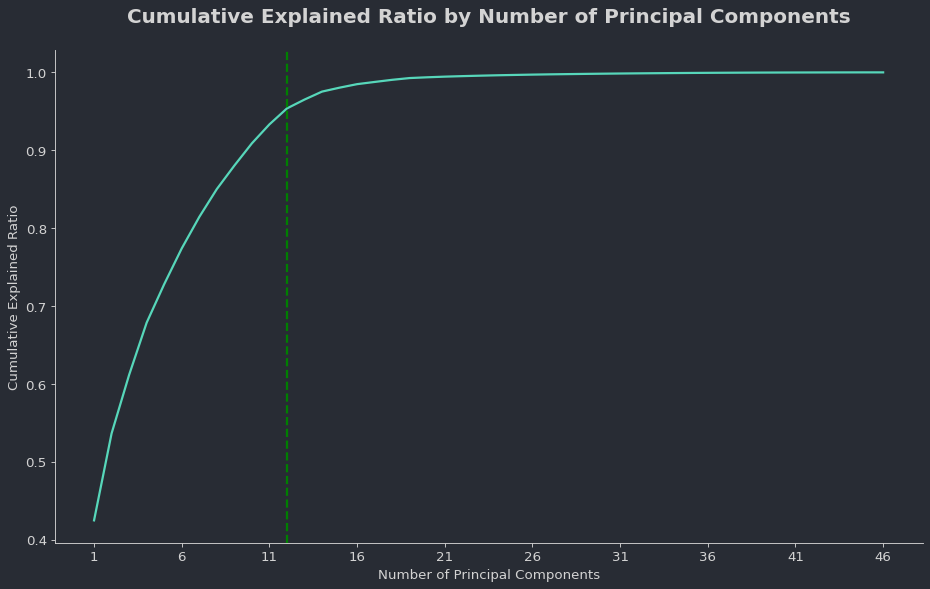

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.plot(cum_evr)
ax.set_xticks(np.arange(0, len(housing_variables), 5))
ax.set_xticklabels(np.arange(0, len(housing_variables), 5) + 1, rotation = 0)

ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Ratio')
ax.set_title('Cumulative Explained Ratio by Number of Principal Components')

#Vertical Line here at 11 really means 12 components
ax.axvline(11, linestyle = '--', color='green')

plt.show()

In [ ]:
"{:.2%}".format(cum_evr[11]) #note that 11 is the 12th component

'95.37%'

A PCA with **12 principal components** allows us to capture 95% of the variability within the housing variables.

In [ ]:
pca = PCA(n_components = 12)
pca.fit(app_train_housing[housing_variables])

PCA(n_components=12)

In [ ]:
app_train_housing = pd.concat([app_train_housing,pd.DataFrame(pca.transform(app_train_housing[housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = app_train_housing.index)],axis = 1)


In [ ]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(app_train_housing[['housing_pca_' + str(x) for x in range(1,13)]],app_train_housing['target'], test_size = 0.3, random_state = seed)


In [ ]:
#Note that we must oversample or undersample to account for the imbalance in the target variable. We will use oversampling here.
d['application_train_df'].target.value_counts()


0    282686
1     24825
Name: target, dtype: int64

In [ ]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)


In [ ]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))

53.60%


While not a huge boost to predictability, with solely the housing PCA components, we see a 53.6% accuracy score, thus we will keep these features and our model may or may not select them in the future. We will fill in the missing values and perform the modeling again to ensure we get consistent results after filling in nulls values. Many rows have some of the housing variables, with some (or many) being null

In [ ]:
for col in housing_variables:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


In [ ]:
#PCA on train and test after filling nulls. Using the PCA fit on the subset that had no null values
d['application_train_df'] = pd.concat([d['application_train_df'],pd.DataFrame(pca.transform(d['application_train_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_train_df'].index)],axis = 1)
d['application_test_df'] = pd.concat([d['application_test_df'],pd.DataFrame(pca.transform(d['application_test_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_test_df'].index)],axis = 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'][['housing_pca_' + str(x) for x in range(1,13)]],d['application_train_df']['target'], test_size = 0.3, random_state = seed)
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)


In [ ]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))


53.79%


The predictability remained consistent after populating the `null` values with the mean.

In [ ]:
#Drop the housing variables that are not the PCA components
d['application_train_df'].drop(columns = housing_variables,inplace=True)
d['application_test_df'].drop(columns = housing_variables,inplace=True)


Let's look at a pairplot.

In [ ]:
#
#df = d['application_train_df']
#df = df[list(high_correlation_features)]
#df.head()

In [ ]:
#sns.pairplot(data = df)

Now, let's plot the distribution of the categorical variables using `sns.countplot()`.

In [ ]:
# gets the columns that have categorical variables

object_columns = d['application_train_df'].select_dtypes(include=['object']).columns.tolist()
object_columns


['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'fondkapremont_mode']

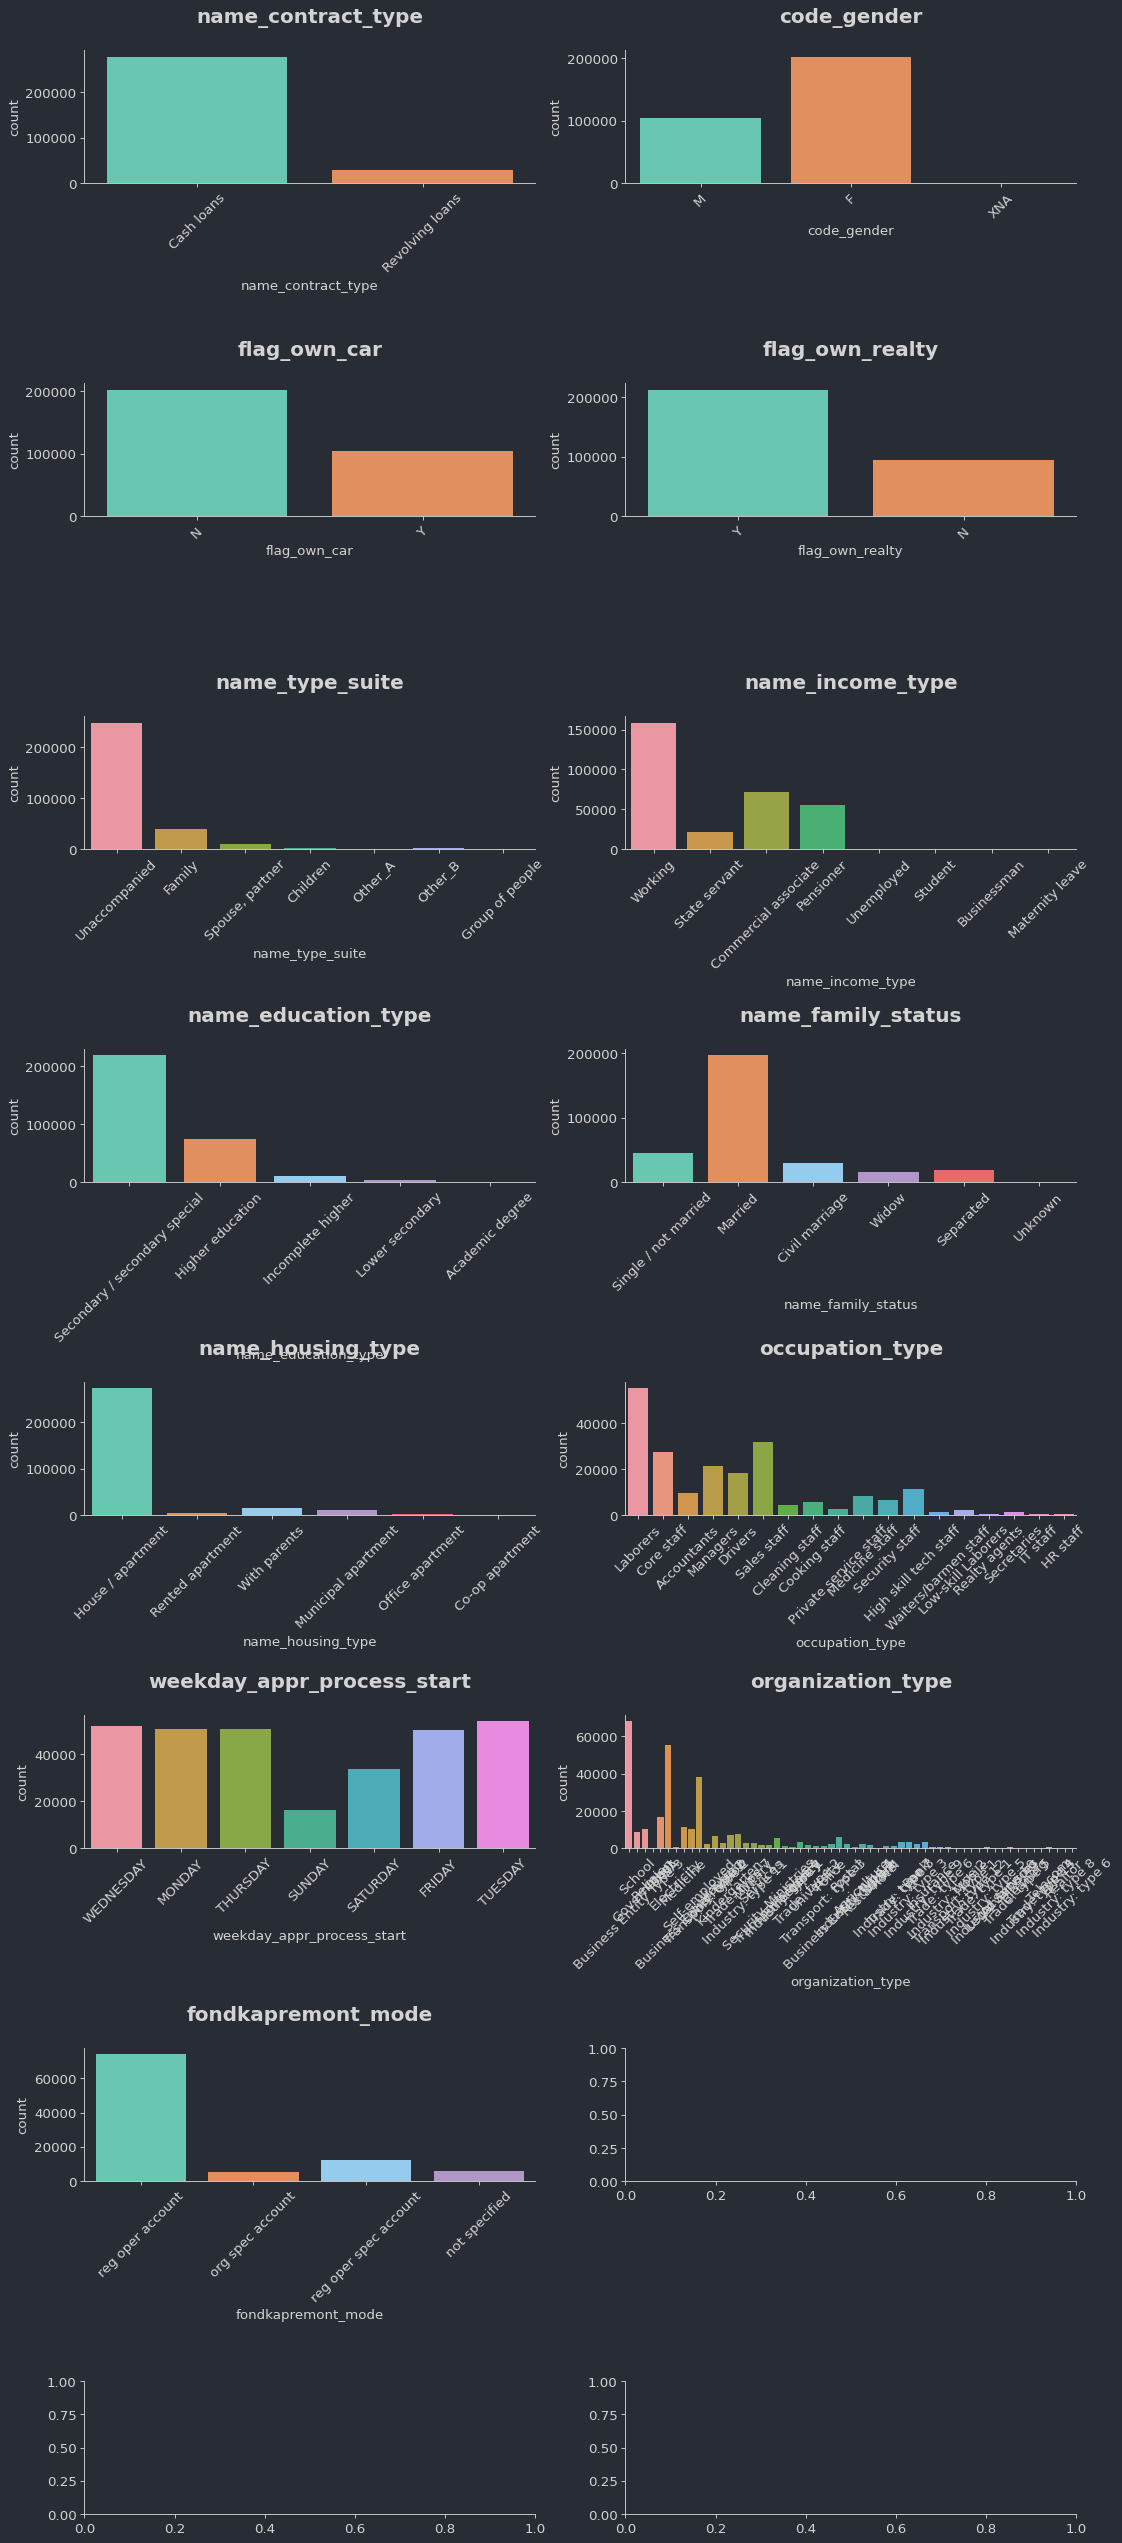

In [ ]:
# plot the categorical variables

# define height ratios for the subplots
height_ratios = [50] * 7 + [50]

# create an 8x2 subplot grid
fig, axes = plt.subplots(8, 2, figsize=(16, 40), gridspec_kw={'height_ratios': height_ratios})

plt.subplots_adjust(hspace = 1.5)

# flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(object_columns):
    sns.countplot(x = column, data = d['application_train_df'], ax = axes[i])
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)

#plt.tight_layout(h_pad = 2.5)
plt.show()

In [ ]:
# initial impressions
# predominent:  married females with a secondary education who own a home (but don't own a car) applying for cash loans

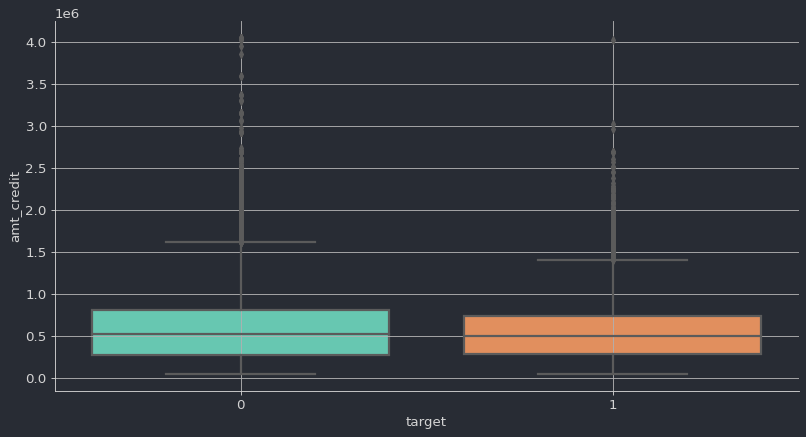

In [ ]:
# Does a large amount of credit result in a default condition?  No!

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'amt_credit')
plt.grid()
plt.show()

In [ ]:
# Is there a greater incidence of default among male borrowers?  Yes! (about 300 basis points greater than for female borrowers)

gender_target_counts = d['application_train_df'].groupby(['code_gender', 'target']).size()

gender_target_counts_unstacked = gender_target_counts.unstack('target')

percentage_defaults_by_gender = gender_target_counts_unstacked.div(gender_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#Changing gender to a binary variable with 1 = Female, 0 Otherwise
d['application_train_df']['code_gender']  = np.where(d['application_train_df']['code_gender'] == 'F',1,0)
d['application_test_df']['code_gender']  = np.where(d['application_test_df']['code_gender'] == 'F',1,0)

target                0          1
code_gender                       
F             93.000672   6.999328
M             89.858080  10.141920
XNA          100.000000        NaN


In [ ]:
# Do borrowers who own a realty default more than borrowers who do not?  Approximately equal, but home owners are slightly less likely to default.

own_realty_target_counts = d['application_train_df'].groupby(['flag_own_realty', 'target']).size()

own_realty_target_counts_unstacked = own_realty_target_counts.unstack('target')

percentage_defaults_by_gender = own_realty_target_counts_unstacked.div(own_realty_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

d['application_train_df']['flag_own_realty']  = np.where(d['application_train_df']['flag_own_realty'] == 'Y',1,0)
d['application_test_df']['flag_own_realty']  = np.where(d['application_test_df']['flag_own_realty'] == 'Y',1,0)

target                   0         1
flag_own_realty                     
N                91.675071  8.324929
Y                92.038423  7.961577


In [ ]:
# Does the number of children impact default rates?  Approximately equal between 1-2 children, then seemingly impacted between 3-6 children. No children has the lowest default rate.

cnt_children_target_counts = d['application_train_df'].groupby(['cnt_children', 'target']).size()

cnt_children_target_counts_unstacked = cnt_children_target_counts.unstack('target')

percentage_defaults_by_gender = cnt_children_target_counts_unstacked.div(cnt_children_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#convert into 2 binary variables, one for having one child, one for having multiple children. People with multiple children will have a 1 in both columns
d['application_train_df']['has_child']  = np.where(d['application_train_df']['cnt_children'] > 0,1,0)
d['application_test_df']['has_child']  = np.where(d['application_test_df']['cnt_children'] > 0,1,0)

d['application_train_df']['has_multiple_children']  = np.where(d['application_train_df']['cnt_children'] > 1,1,0)
d['application_test_df']['has_multiple_children']  = np.where(d['application_test_df']['cnt_children'] > 1,1,0)

d['application_train_df'].drop('cnt_children',axis=1,inplace=True)
d['application_test_df'].drop('cnt_children',axis=1,inplace=True)

target                 0           1
cnt_children                        
0              92.288191    7.711809
1              91.076425    8.923575
2              91.278179    8.721821
3              90.368577    9.631423
4              87.179487   12.820513
5              91.666667    8.333333
6              71.428571   28.571429
7             100.000000         NaN
8             100.000000         NaN
9                    NaN  100.000000
10            100.000000         NaN
11                   NaN  100.000000
12            100.000000         NaN
14            100.000000         NaN
19            100.000000         NaN


In [ ]:
# Do borrowers who own a car default more than those who do not?  Car owners are less likely to default

own_car_target_counts = d['application_train_df'].groupby(['flag_own_car', 'target']).size()

own_car_target_counts_unstacked = own_car_target_counts.unstack('target')

percentage_defaults_by_gender = own_car_target_counts_unstacked.div(own_car_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

target                0         1
flag_own_car                     
N             91.499773  8.500227
Y             92.756270  7.243730


(0.0, 40.0)

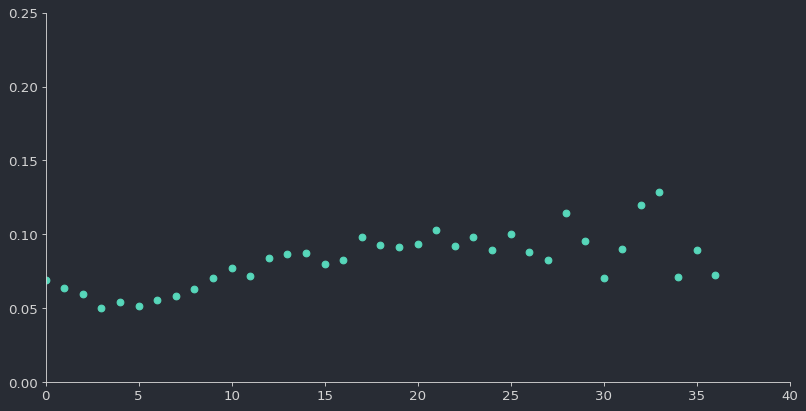

In [ ]:
# Age of Car -- is correlated with default, but with the range of values so it may be better to take the log of this value
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,40)

# TO DO:  add axes titles and plot title

(0.0, 5.0)

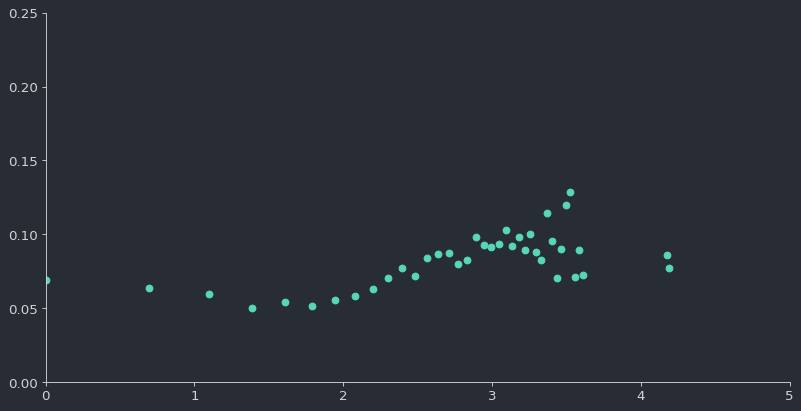

In [ ]:
# Car age is correlated, so let's just take the log of it, adding 1 to avoid an -inf error

d['application_train_df']['own_car_age'] = np.log(d['application_train_df']['own_car_age'] + 1)
d['application_test_df']['own_car_age'] = np.log(d['application_test_df']['own_car_age'] + 1)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,5)

# TO DO:  add axes titles and plot title

Virtually all values with a NULL `own_car_age` has a "N" for `flag_own_car`, thus we do not need another binary variable reprenting that `own_car_age` is NULL. We fill the null `own_car_age` with the mean

In [ ]:
d['application_train_df']['own_car_age'].mean()


2.246389474295695

In [ ]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'target'].mean()


0.08500017247411656

In [ ]:
d['application_train_df']['flag_own_car'].isna().sum()


0

In [ ]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'flag_own_car'].value_counts()


N    202924
Y         5
Name: flag_own_car, dtype: int64

In [ ]:
d['application_train_df']['own_car_age'].fillna(d['application_train_df']['own_car_age'].mean(),inplace=True)
d['application_test_df']['own_car_age'].fillna(d['application_test_df']['own_car_age'].mean(),inplace=True)


There does seem to be some correlation with hour of application, although this may be a fluke.
People who apply in the early-morning have the highest default rate, morning (pre-noon) ,followed by night and then day

In [ ]:

def hour_of_application(hour):
    if hour > 17 or hour < 4:
        return 'night'
    elif hour < 9:
        return 'early-morning'
    elif hour <= 12:
        return 'morning'
    else:
        return 'afternoon'

In [ ]:
d['application_train_df']['hour_appr_process_start'].apply(hour_of_application).value_counts()


morning          136568
afternoon        118765
early-morning     35828
night             16350
Name: hour_appr_process_start, dtype: int64

In [ ]:
d['application_train_df']['hour_appr_process_start'] = d['application_train_df']['hour_appr_process_start'].apply(hour_of_application)
d['application_test_df']['hour_appr_process_start'] = d['application_test_df']['hour_appr_process_start'].apply(hour_of_application)


(0.0, 0.1)

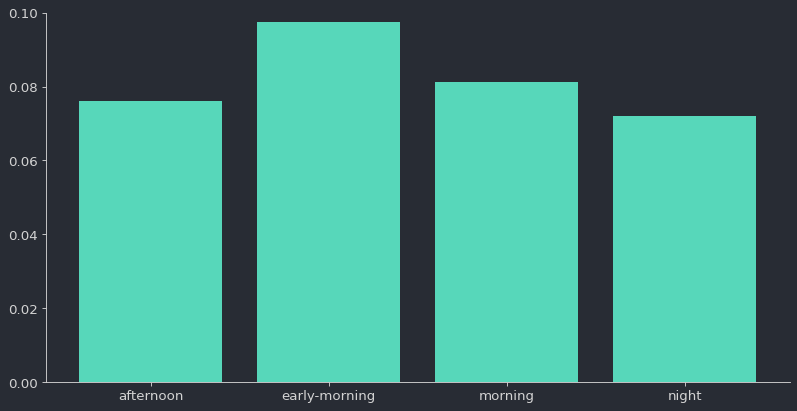

In [ ]:
#There may be a correlation with when people start their application
col = 'hour_appr_process_start'
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].index, height = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].values)

ax.set_ylim(0,0.1)

# # TO DO:  add axes titles and plot title

In [ ]:
# Values other than 'Working','Commercial associate','Pensioner','State servant' are extremely rare for the columns 'name_income_type' and will be grouped into an 'Other' category

print(d['application_train_df']['name_income_type'].value_counts())

d['application_train_df'].loc[~d['application_train_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: name_income_type, dtype: int64


In [ ]:
# majority of people are solo. Other then Family / spouse or partner, it's pretty sparse, so not worth one-hot encoding. Instead, we have a binary variable for "lives_alone"

print(d['application_train_df']['name_type_suite'].value_counts())

d['application_train_df']['lives_alone']  = np.where(d['application_train_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_train_df'].drop('name_type_suite',axis=1,inplace=True)

d['application_test_df']['lives_alone']  = np.where(d['application_test_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_test_df'].drop('name_type_suite',axis=1,inplace=True)

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: name_type_suite, dtype: int64


In [ ]:
print(d['application_train_df']['name_education_type'].value_counts())

#grouping in Academic Degree with Higher Education as it is a form of Higher Education and there are only 164 rows with Academic Degree
d['application_train_df'].loc[d['application_train_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'
d['application_test_df'].loc[d['application_test_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: name_education_type, dtype: int64


In [ ]:
#unknown is 2 samples. saving a column by just making it Single / not married

print(d['application_train_df']['name_family_status'].value_counts())
d['application_train_df'].loc[d['application_train_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'
d['application_test_df'].loc[d['application_test_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: name_family_status, dtype: int64


In [ ]:
#Why are House / apartment not seperated? -- Makes this feature essentially useless. Will keep this as is and will one-hot encode it

d['application_train_df']['name_housing_type'].value_counts()

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: name_housing_type, dtype: int64

In [ ]:
d['application_train_df'].groupby('name_housing_type').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target').reset_index()


,name_housing_type,target,sk_id_curr
0,Office apartment,0.065724,2617
1,House / apartment,0.077957,272868
2,Co-op apartment,0.079323,1122
3,Municipal apartment,0.085397,11183
4,With parents,0.116981,14840
5,Rented apartment,0.123131,4881


In [ ]:
d['application_test_df']['name_housing_type'].value_counts()


House / apartment      43645
With parents            2234
Municipal apartment     1617
Rented apartment         718
Office apartment         407
Co-op apartment          123
Name: name_housing_type, dtype: int64

In [ ]:
d['application_train_df'][[x for x in d['application_train_df'].columns if 'amt_req_credit' in x]].isna().sum()


amt_req_credit_bureau_hour    41519
amt_req_credit_bureau_day     41519
amt_req_credit_bureau_week    41519
amt_req_credit_bureau_mon     41519
amt_req_credit_bureau_qrt     41519
amt_req_credit_bureau_year    41519
dtype: int64

For the `amt_req_credit` columns, these represent how many credit pulls they've had during certain time periods. The null values have a higher default rate, so we will fill the nulls with a mean and have a dummy variable for `unknown_credit`

In [ ]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    print(col)
    print(d['application_train_df'][col].value_counts())

amt_req_credit_bureau_hour
0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: amt_req_credit_bureau_hour, dtype: int64
amt_req_credit_bureau_day
0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: amt_req_credit_bureau_day, dtype: int64
amt_req_credit_bureau_week
0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: amt_req_credit_bureau_week, dtype: int64
amt_req_credit_bureau_mon
0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
23.0         1
27.0         1
22.0         1
Name: amt_req_credit_bureau_mon, dtype: int64
amt_req_credit_bureau_qrt


In [ ]:
d['application_train_df'].groupby('amt_req_credit_bureau_year')['target'].mean()


amt_req_credit_bureau_year
0.0     0.071350
1.0     0.073338
2.0     0.081049
3.0     0.079577
4.0     0.082553
5.0     0.083223
6.0     0.090713
7.0     0.092013
8.0     0.086037
9.0     0.108577
10.0    0.136364
11.0    0.064516
12.0    0.066667
13.0    0.052632
14.0    0.300000
15.0    0.000000
16.0    0.333333
17.0    0.000000
18.0    0.000000
19.0    0.000000
20.0    0.000000
21.0    0.000000
22.0    1.000000
23.0    0.000000
25.0    0.000000
Name: target, dtype: float64

In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_req_credit_bureau_year'].isna(),'target'].mean()


0.10337435872732965

In [ ]:
d['application_train_df']['amt_req_credit_bureau_year'].mean()


1.899974435321363

In [ ]:
#dummy variable for the people with missing credit

d['application_train_df']['unknown_credit'] = np.where(d['application_train_df']['amt_req_credit_bureau_year'].isna(),1,0)
d['application_test_df']['unknown_credit'] = np.where(d['application_test_df']['amt_req_credit_bureau_year'].isna(),1,0)


In [ ]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


To fill the nulls in `amt_annuity`, we will use the ratio of `amt_annuity` and `amt_credit` due to the high correlation. Could additionally be modeled, but not worth the time investment due to the small amount of rows

In [ ]:
d['application_train_df']['amt_annuity'].isna().sum()

12

In [ ]:
d['application_test_df']['amt_annuity'].isna().sum()

24

In [ ]:
d['application_train_df'][['amt_annuity','amt_credit']].corr()


,amt_annuity,amt_credit
amt_annuity,1.000000,0.770138
amt_credit,0.770138,1.000000


In [ ]:
annuity_to_credit_ratio = (d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_credit']).mean()


In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio


In [ ]:
d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio


The instances where `amt_goods_price` is null are all revolving loans, making up 1% of the revolving loans. We will set them to the amt_credit in this case due to the correlation

In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_goods_price'].isna(),'name_contract_type'].value_counts()


Revolving loans    278
Name: name_contract_type, dtype: int64

In [ ]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] == 'Revolving loans',['amt_credit','amt_goods_price']].corr()


,amt_credit,amt_goods_price
amt_credit,1.000000,0.994901
amt_goods_price,0.994901,1.000000


In [ ]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] != 'Revolving loans',['amt_credit','amt_goods_price']].corr()


,amt_credit,amt_goods_price
amt_credit,1.000000,0.986884
amt_goods_price,0.986884,1.000000


In [ ]:
d['application_train_df']['amt_goods_price'].fillna(d['application_train_df']['amt_credit'],inplace=True)
d['application_test_df']['amt_goods_price'].fillna(d['application_test_df']['amt_credit'],inplace=True)


There is only one null value for this `days_last_phone_change`, so we will just fill it with the mean
It is interesting that 12% of the values have `0` as the value for this. This means that 12% of people applying for loans changed their number that day. While it may make sense to make these values null, there is a possibility that recently changing your phone number and applying for credit is correlated. A lot of people applying for emergency funding loans / personal credit loans may be going through something that requires them to also get a new phone number. Due to the possibility of this being rational, we will not void the values of `0`. These observations have higher probability to default, so we will create an additional dummy variable to catch any non-linearity of this relationship.

In [ ]:
d['application_train_df']['days_last_phone_change'].isna().sum()


1

In [ ]:
d['application_train_df']['days_last_phone_change'].value_counts()


 0.0       37672
-1.0        2812
-2.0        2318
-3.0        1763
-4.0        1285
           ...  
-4051.0        1
-3593.0        1
-3622.0        1
-3570.0        1
-3538.0        1
Name: days_last_phone_change, Length: 3773, dtype: int64

In [ ]:
d['application_train_df']['days_last_phone_change'].fillna(d['application_train_df']['days_last_phone_change'].mean(),inplace=True)
d['application_test_df']['days_last_phone_change'].fillna(d['application_test_df']['days_last_phone_change'].mean(),inplace=True)

In [ ]:
d['application_train_df'].loc[d['application_train_df']['days_last_phone_change'] == 0,'target'].mean()

0.0966500318538968

In [ ]:
d['application_train_df'].loc[d['application_train_df']['days_last_phone_change'] != 0,'target'].mean()

0.0785060721393127

In [ ]:
d['application_train_df']['changed_phone_day_of'] = np.where(d['application_train_df']['days_last_phone_change'] == 0,1,0)
d['application_test_df']['changed_phone_day_of'] = np.where(d['application_test_df']['days_last_phone_change'] == 0,1,0)

Only two null values in `cnt_fam_members`, but seemingly no correlation to default rate. Will fill with mean

In [ ]:
d['application_train_df']['cnt_fam_members'].isna().sum()


2

In [ ]:
d['application_train_df']['cnt_fam_members'].value_counts()


2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: cnt_fam_members, dtype: int64

In [ ]:
d['application_train_df']['cnt_fam_members'].fillna(d['application_train_df']['cnt_fam_members'].mean(),inplace=True)
d['application_test_df']['cnt_fam_members'].fillna(d['application_test_df']['cnt_fam_members'].mean(),inplace=True)


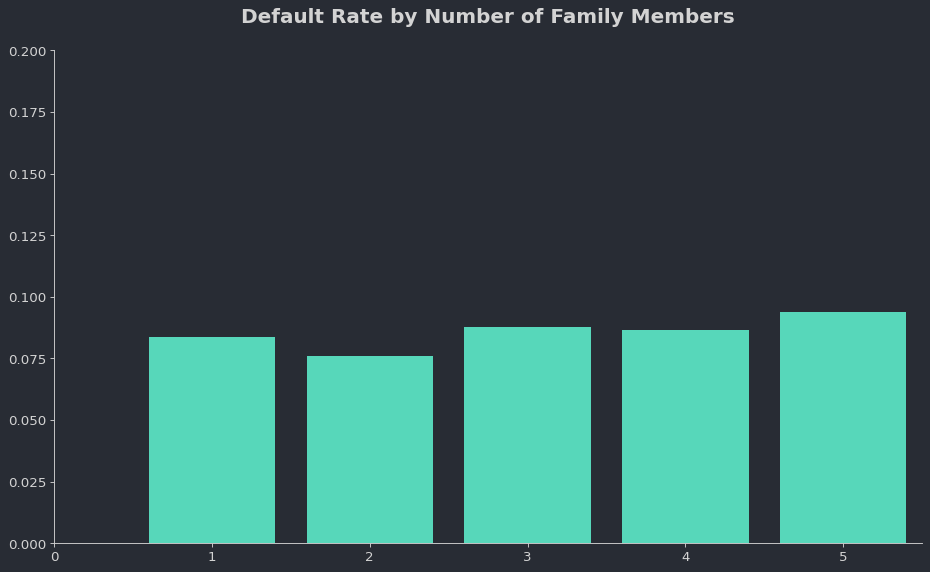

In [ ]:
col = 'cnt_fam_members'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])


ax.set_xlim(0,5.5) #cut this off at 5 b/c there is very few samples of 6+
ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Number of Family Members')

plt.show()

# TO DO:  add axes titles

## External Sources (3 columns labeled with suffix _1, _2, and _3)
- NOTE: Rerun these. I ran these again after dealing with external source 1. Then delete this comment

In [ ]:
for i in range(1,4,1):
    pct_null = d['application_train_df'][f'ext_source_{i}'].isna().sum() / len(d['application_train_df'])
    print(f'Percent of null values in training dataset for ext_source_{i}: {pct_null:.3%}')

Percent of null values in training dataset for ext_source_1: 56.381%
Percent of null values in training dataset for ext_source_2: 0.215%
Percent of null values in training dataset for ext_source_3: 19.825%


In [ ]:
for i in range(1,4,1):
    pct_null = d['application_test_df'][f'ext_source_{i}'].isna().sum() / len(d['application_train_df'])
    print(f'Percent of null values in the test dataset for ext_source_{i}: {pct_null:.3%}')

Percent of null values in the test dataset for ext_source_1: 6.677%
Percent of null values in the test dataset for ext_source_2: 0.003%
Percent of null values in the test dataset for ext_source_3: 2.819%


In [ ]:
temp = d['application_train_df'][['target','ext_source_1','ext_source_2','ext_source_3']].copy()

In [ ]:
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_2_bin'] = pd.qcut(temp['ext_source_2'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_3_bin'] = pd.qcut(temp['ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))

In [ ]:
temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_2_bin').agg({'target':'mean'})
temp3 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})

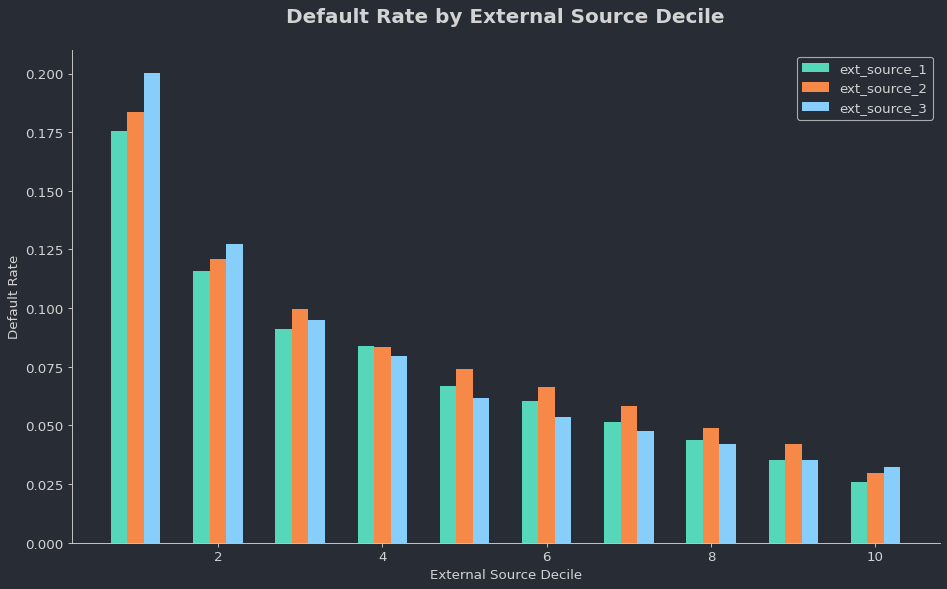

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_2')
ax.bar(x = np.arange(1,11,1) + 0.2, height = temp3['target'].values, width = 0.2, label = 'ext_source_3')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source Decile')

ax.legend()

plt.show()

In [ ]:
temp.corr()


<ipython-input-111-79cec36d1758>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp.corr()


,target,ext_source_1,ext_source_2,ext_source_3
target,1.000000,-0.155317,-0.160472,-0.178919
ext_source_1,-0.155317,1.000000,0.213982,0.186846
ext_source_2,-0.160472,0.213982,1.000000,0.109167
ext_source_3,-0.178919,0.186846,0.109167,1.000000


We can see above that the 3 External sources are very predictive in sloping default rates, and the correlation between the values is reasonable (~20%) with one another. It is worth attempting to model the nulls for `ext_source_1`, if possible.

In [ ]:
ext_source_1_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_1']


In [ ]:
ext_source_1_corr[ext_source_1_corr.abs() > 0.05]


target                        -0.155317
code_gender                    0.306729
flag_own_realty                0.080234
amt_credit                     0.168429
amt_annuity                    0.119402
amt_goods_price                0.175649
region_population_relative     0.099997
days_birth                    -0.600610
days_employed                  0.289848
days_registration             -0.181095
days_id_publish               -0.132375
own_car_age                   -0.064478
flag_emp_phone                -0.294147
flag_work_phone               -0.076540
flag_phone                     0.081241
cnt_fam_members               -0.096569
region_rating_client          -0.115341
region_rating_client_w_city   -0.115374
reg_city_not_live_city        -0.141000
reg_city_not_work_city        -0.185953
live_city_not_work_city       -0.119300
ext_source_1                   1.000000
ext_source_2                   0.213982
ext_source_3                   0.186846
days_last_phone_change        -0.132607


In [ ]:
# remove all the other external source columns and the target column
features_to_model_ext_source_1 = [x for x in d['application_train_df'].isna().sum()[ext_source_1_corr[ext_source_1_corr.abs() > 0.05].index].index if x not in ['target','ext_source_1','ext_source_2','ext_source_3']]


In [ ]:
d['application_train_df'].isna().sum()[features_to_model_ext_source_1]


code_gender                    0
flag_own_realty                0
amt_credit                     0
amt_annuity                    0
amt_goods_price                0
region_population_relative     0
days_birth                     0
days_employed                  0
days_registration              0
days_id_publish                0
own_car_age                    0
flag_emp_phone                 0
flag_work_phone                0
flag_phone                     0
cnt_fam_members                0
region_rating_client           0
region_rating_client_w_city    0
reg_city_not_live_city         0
reg_city_not_work_city         0
live_city_not_work_city        0
days_last_phone_change         0
flag_document_6                0
flag_document_8                0
housing_pca_1                  0
housing_pca_7                  0
housing_pca_10                 0
housing_pca_11                 0
housing_pca_12                 0
has_child                      0
has_multiple_children          0
unknown_cr

### TODO: Improve Modeling technique to predict External Source 1. Maybe some feature selection? This is a placeholder

Due to the importance of `ext_source_1`, we model out the missing values using other dataset features and have a dummy variable that indicates if it was previously null and now modeled to capture the delta

In [ ]:
#Build a Lasso regression to predict ext_source_1

X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),features_to_model_ext_source_1],d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),'ext_source_1'], test_size = 0.3, random_state = seed)

ridge_reg = Ridge(random_state=seed,alpha = 1).fit(X_train, y_train)


In [ ]:
ridge_reg.score(X_test,y_test)


0.4554275675764087

In [ ]:
d['application_train_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_1])
d['application_test_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_1])


In [ ]:
d['application_train_df']['null_ext_source_1'] = np.where(d['application_train_df']['ext_source_1'].isna(),1,0)
d['application_test_df']['null_ext_source_1'] = np.where(d['application_test_df']['ext_source_1'].isna(),1,0)


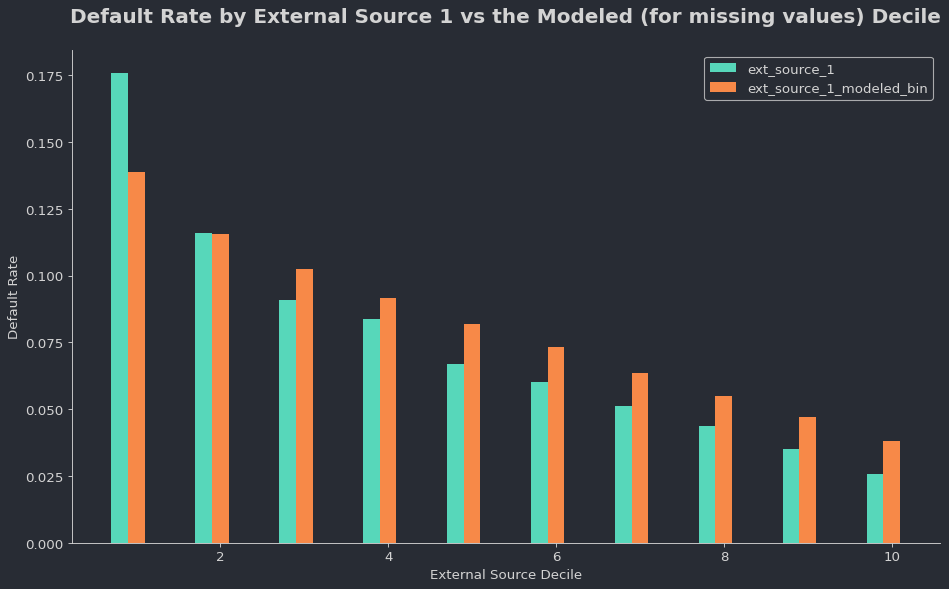

In [ ]:
temp = d['application_train_df'][['target','ext_source_1','modeled_ext_source_1']].copy()
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_1_modeled_bin'] = pd.qcut(temp['modeled_ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))


temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_1_modeled_bin').agg({'target':'mean'})

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_1_modeled_bin')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source 1 vs the Modeled (for missing values) Decile')

ax.legend()

plt.show()

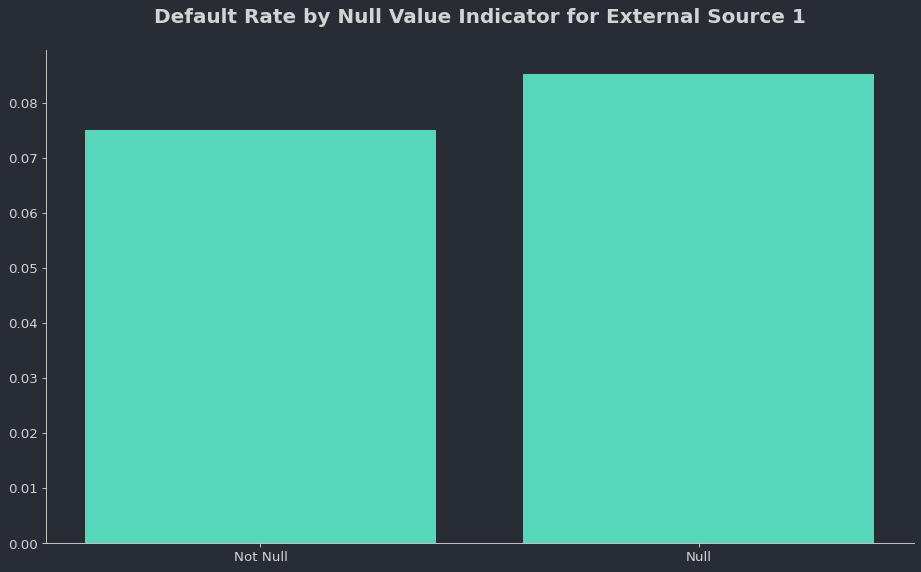

In [ ]:
col = 'null_ext_source_1'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Null Value Indicator for External Source 1')

ax.set_xticks([0,1])
ax.set_xticklabels(['Not Null','Null'])

plt.show()

In [ ]:
# Fill nulls with the modeled values. Drop Modeled values

d['application_train_df']['ext_source_1'].fillna(d['application_train_df']['modeled_ext_source_1'],inplace=True)
d['application_test_df']['ext_source_1'].fillna(d['application_test_df']['modeled_ext_source_1'],inplace=True)

d['application_train_df'].drop(columns = ['modeled_ext_source_1'],inplace=True)
d['application_test_df'].drop(columns = ['modeled_ext_source_1'],inplace=True)

We will repeat this process for `ext_source_2` as 20% of the training data is null. Only 3% of the test data is null for this column.

In [ ]:
ext_source_2_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_2']

In [ ]:
ext_source_2_corr[ext_source_2_corr.abs() > 0.05]

target                        -0.160472
amt_income_total               0.060925
amt_credit                     0.131228
amt_annuity                    0.125788
amt_goods_price                0.139330
region_population_relative     0.198924
days_birth                    -0.091996
days_registration             -0.059913
days_id_publish               -0.050955
own_car_age                   -0.060356
flag_phone                     0.061178
region_rating_client          -0.292895
region_rating_client_w_city   -0.288299
reg_city_not_work_city        -0.075970
live_city_not_work_city       -0.058900
ext_source_1                   0.179242
ext_source_2                   1.000000
ext_source_3                   0.109167
days_last_phone_change        -0.195764
flag_document_8                0.050684
housing_pca_1                  0.074238
housing_pca_7                 -0.073070
housing_pca_9                  0.051201
housing_pca_10                 0.111937
housing_pca_11                -0.114643


`ext_source_2` is also very predictive, but only 0.21% of the values are null, so we will drop these rows and fill in the missing values in the test dataset with the mean
<br> (only 0.003% of test values are null)

In [ ]:

d['application_train_df'].dropna(subset = ['ext_source_2'],inplace=True)
d['application_test_df']['ext_source_2'].fillna(d['application_test_df']['ext_source_2'].mean(),inplace=True)


## TODO: talk with team to see if we should use other external source columns to model external_source_3. That or we need to improve this modeling technique

In [ ]:
ext_source_3_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_3']

In [ ]:
# remove all the other external source columns and the target column

features_to_model_ext_source_3 = [x for x in d['application_train_df'].isna().sum()[ext_source_3_corr[ext_source_3_corr.abs() > 0.05].index].index if x not in ['target','ext_source_1','ext_source_2','ext_source_3']]

In [ ]:
# 77% overlap between the variables in the two models

len([x for x in features_to_model_ext_source_3 if x in features_to_model_ext_source_1]) / len(features_to_model_ext_source_3)

0.7692307692307693

In [ ]:
#Build a Lasso regression to predict ext_source_1

X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'].loc[d['application_train_df']['ext_source_3'].notna(),
                                                                                  features_to_model_ext_source_3],
                                                                                  d['application_train_df'].loc[d['application_train_df']['ext_source_3'].notna(),'ext_source_3'],
                                                                                  test_size = 0.3, random_state = seed + 1) #seed + 1 to avoid the same split as the previous model for ext_source_1

ridge_reg = Ridge(random_state=seed,alpha = 1).fit(X_train, y_train)


In [ ]:
ridge_reg.score(X_test,y_test)

0.0676781534849542

In [ ]:
d['application_train_df']['modeled_ext_source_3'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_3])
d['application_test_df']['modeled_ext_source_3'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_3])


In [ ]:
d['application_train_df']['null_ext_source_3'] = np.where(d['application_train_df']['ext_source_3'].isna(),1,0)
d['application_test_df']['null_ext_source_3'] = np.where(d['application_test_df']['ext_source_3'].isna(),1,0)


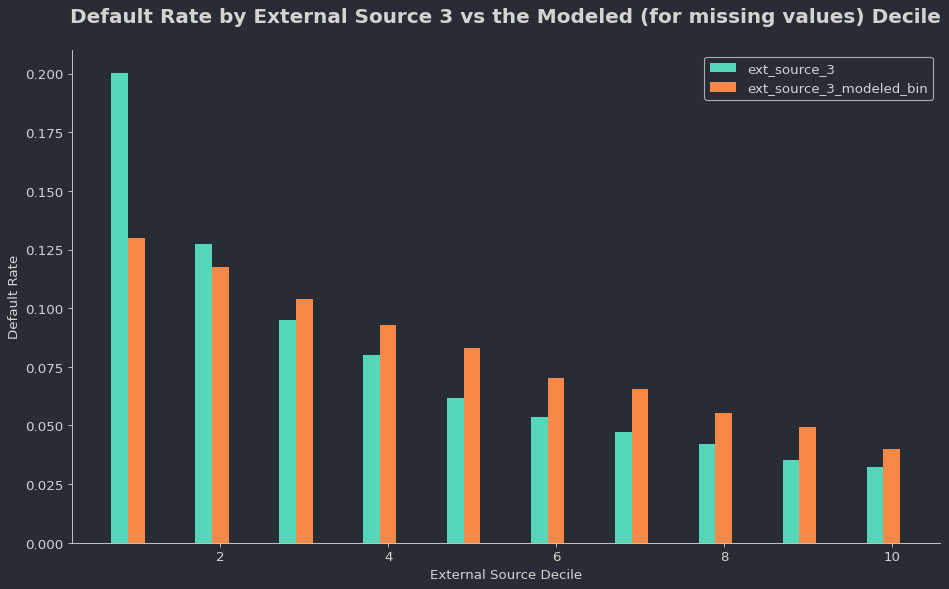

In [ ]:
temp = d['application_train_df'][['target','ext_source_3','modeled_ext_source_3']].copy()
temp['ext_source_3_bin'] = pd.qcut(temp['ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_3_modeled_bin'] = pd.qcut(temp['modeled_ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))


temp1 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_3_modeled_bin').agg({'target':'mean'})

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)


ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_3')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_3_modeled_bin')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source 3 vs the Modeled (for missing values) Decile')

ax.legend()

plt.show()

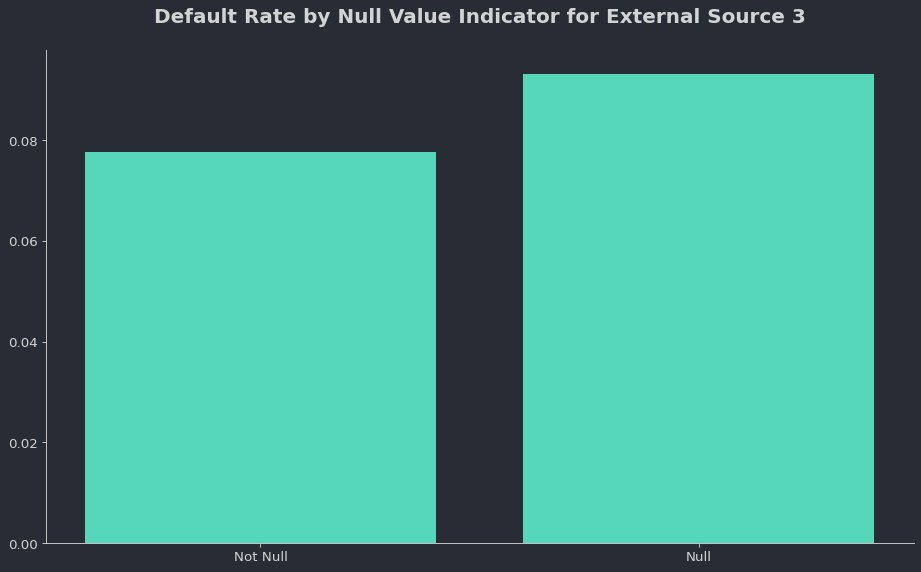

In [ ]:

col = 'null_ext_source_3'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Null Value Indicator for External Source 3')

ax.set_xticks([0,1])
ax.set_xticklabels(['Not Null','Null'])

plt.show()

# TO DO:  add axes titles

In [ ]:
# Fill nulls with the modeled values. Drop Modeled values

d['application_train_df']['ext_source_3'].fillna(d['application_train_df']['modeled_ext_source_3'],inplace=True)
d['application_test_df']['ext_source_3'].fillna(d['application_test_df']['modeled_ext_source_3'],inplace=True)

d['application_train_df'].drop(columns = ['modeled_ext_source_3'],inplace=True)
d['application_test_df'].drop(columns = ['modeled_ext_source_3'],inplace=True)

Not sure what the column `fondkapremont_mode` means, but the categorical variable seems to slope to default somewhat, especially with Missing values having the highest default rate. The variable name and the column description is not informative

In [ ]:
d['application_train_df']['fondkapremont_mode'].value_counts()

reg oper account         73679
reg oper spec account    12059
not specified             5672
org spec account          5614
Name: fondkapremont_mode, dtype: int64

In [ ]:

d['application_train_df']['fondkapremont_mode'].fillna('missing',inplace=True)
d['application_test_df']['fondkapremont_mode'].fillna('missing',inplace=True)


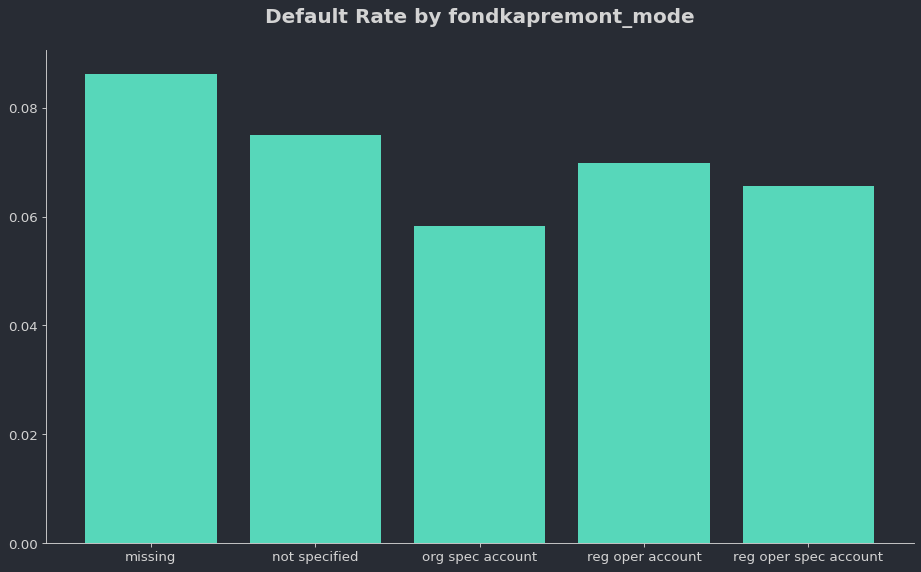

''

In [ ]:
col = 'fondkapremont_mode'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by fondkapremont_mode')

plt.show()


ax.set_xlabel('Fondkapremont Mode')
ax.set_ylabel('Default Rate')

;

For `occupation_type`, nulls are theoretically have value because no known occupation hypothetically may be indicative of default risk. Off of a simple aggregation, it is not, but there may be hidden relationships with other variables

In [ ]:
d['application_train_df']['occupation_type'].fillna('Unknown',inplace=True)
d['application_test_df']['occupation_type'].fillna('Unknown',inplace=True)


In [ ]:
d['application_train_df']['occupation_type'].value_counts()


Unknown                  96143
Laborers                 55084
Sales staff              32015
Core staff               27519
Managers                 21346
Drivers                  18575
High skill tech staff    11361
Accountants               9788
Medicine staff            8513
Security staff            6709
Cooking staff             5932
Cleaning staff            4644
Private service staff     2649
Low-skill Laborers        2087
Waiters/barmen staff      1345
Secretaries               1304
Realty agents              749
HR staff                   563
IT staff                   525
Name: occupation_type, dtype: int64

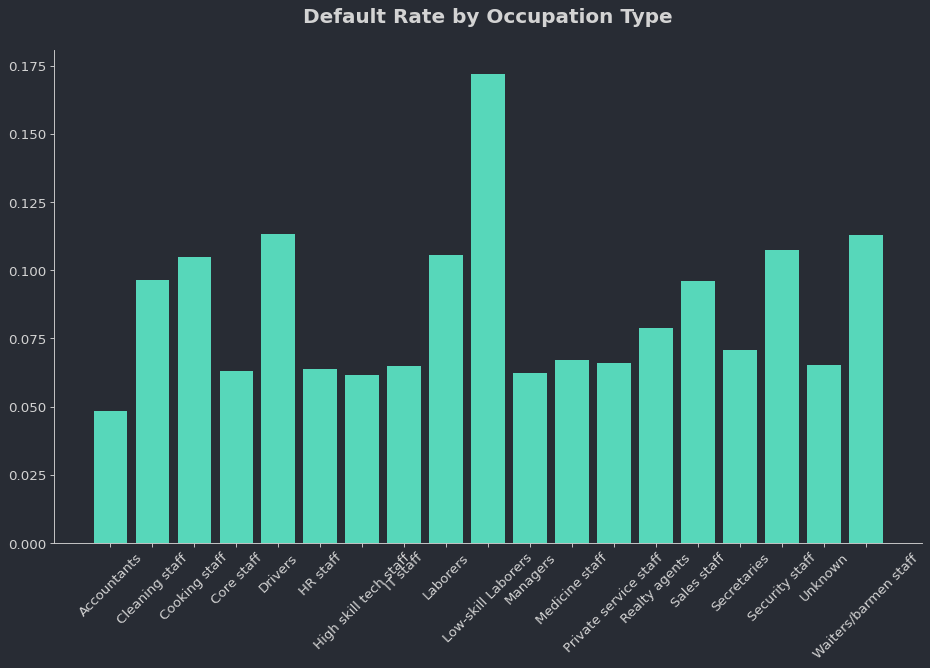

In [ ]:
col = 'occupation_type'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Occupation Type')

plt.xticks(rotation = 45)

plt.show()

There are only a small amount of `null` values for social circle variables (~0.27%), so we will just drop these in the training dataset, and fill the test dataset with the mean.

In [ ]:
d['application_train_df'].isna().sum()[[x for x in d['application_train_df'].columns if 'social_circle' in x]]


obs_30_cnt_social_circle    1017
def_30_cnt_social_circle    1017
obs_60_cnt_social_circle    1017
def_60_cnt_social_circle    1017
dtype: int64

In [ ]:
d['application_test_df'].isna().sum()[[x for x in d['application_train_df'].columns if 'social_circle' in x]]


obs_30_cnt_social_circle    29
def_30_cnt_social_circle    29
obs_60_cnt_social_circle    29
def_60_cnt_social_circle    29
dtype: int64

In [ ]:
d['application_train_df'].dropna(subset = ['obs_30_cnt_social_circle','def_30_cnt_social_circle','obs_60_cnt_social_circle','def_60_cnt_social_circle'],inplace=True)


In [ ]:
for col in ['obs_30_cnt_social_circle','def_30_cnt_social_circle','obs_60_cnt_social_circle','def_60_cnt_social_circle']:
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


In [ ]:
d['application_train_df']['obs_60_cnt_social_circle'].value_counts()


0.0      164274
1.0       48776
2.0       29713
3.0       20174
4.0       13917
5.0        9450
6.0        6341
7.0        4337
8.0        2881
9.0        1953
10.0       1333
11.0        834
12.0        618
13.0        400
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0         13
24.0         12
25.0         11
27.0          5
29.0          2
28.0          1
47.0          1
344.0         1
30.0          1
26.0          1
Name: obs_60_cnt_social_circle, dtype: int64

In [ ]:
d['application_train_df']['def_60_cnt_social_circle'].value_counts()


0.0     280110
1.0      21802
2.0       3165
3.0        597
4.0        135
5.0         20
6.0          3
7.0          1
24.0         1
Name: def_60_cnt_social_circle, dtype: int64

In [ ]:
# We should also try taking the log of each due to the distribution
for col in [x for x in d['application_train_df'].columns if 'social_circle' in x]:
    d['application_train_df'][col + '_log'] = np.log(d['application_train_df'][col] + 1)
    d['application_test_df'][col + '_log'] = np.log(d['application_test_df'][col] + 1)


In [ ]:
d['application_train_df']


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,fondkapremont_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,housing_pca_1,housing_pca_2,housing_pca_3,housing_pca_4,housing_pca_5,housing_pca_6,housing_pca_7,housing_pca_8,housing_pca_9,housing_pca_10,housing_pca_11,housing_pca_12,has_child,has_multiple_children,lives_alone,unknown_credit,changed_phone_day_of,null_ext_source_1,null_ext_source_3,obs_30_cnt_social_circle_log,def_30_cnt_social_circle_log,obs_60_cnt_social_circle_log,def_60_cnt_social_circle_log
0,100002,1,Cash loans,0,N,1,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,2.246389,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,morning,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,reg oper account,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,0.483611,-0.894462,-0.603860,-1.507294,-0.391251,-0.180978,0.031292,-0.547214,0.655574,0.231221,0.045989,-0.214656,0,0,1,0,0,0,0,1.098612,1.098612,1.098612,1.098612
1,100003,0,Cash loans,1,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,2.246389,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,morning,0,0,0,0,0,0,School,0.311267,0.622246,0.497382,reg oper account,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.936382,-1.418267,-0.664634,-1.332093,-0.229277,-0.185672,0.030116,-0.228809,-0.171834,-0.236433,0.937733,-0.321162,0,0,0,0,0,0,1,0.693147,0.000000,0.693147,0.000000
2,100004,0,Revolving loans,0,Y,1,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,3.295837,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,morning,0,0,0,0,0,0,Government,0.512250,0.555912,0.729567,missing,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.996308,-1.110654,-0.687475,-1.414920,-0.242330,-0.194248,-0.011471,-0.234908,-0.194370,-0.288674,0.913786,-0.359487,0,0,1,0,0,1,0,0.000000,0.000000,0.000000,0.000000
3,100006,0,Cash loans,1,N,1,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,2.246389,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,afternoon,0,0,0,0,0,0,Business Entity Type 3,0.655903,0.650442,0.544911,missing,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,0.996308,-1.110654,-0.687475,-1.414920,-0.242330,-0.194248,-0.011471,-0.234908,-0.194370,-0.288674,0.913786

In [ ]:
object_cols = []

for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == 'object':
        object_cols.append(col)


In [ ]:
# one-hot encode all the object columns

for col in object_cols:
    d['application_train_df'] = pd.get_dummies(d['application_train_df'],columns = [col],prefix=col)
    d['application_test_df'] = pd.get_dummies(d['application_test_df'],columns = [col],prefix=col)

In [ ]:
# convert all the boolean columns to int

for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == bool:
        d['application_train_df'][col] = d['application_train_df'][col].astype(int)
        d['application_test_df'][col] = d['application_test_df'][col].astype(int)

In [ ]:
train_cols = d['application_train_df'].columns
test_col = d['application_test_df'].columns

In [ ]:
[x for x in train_cols if x not in test_col]

['target']

In [ ]:
[x for x in test_col if x not in train_cols]

[]

## Novel Features

In [ ]:
#I accidentally overwrote my dataframe but wanted to include these before I hopped of. i.e. no graphs or analysis, just code. Will delete this comment later
d['application_train_df']['payment_to_income_ratio'] = d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_income_total']
d['application_train_df']['additional_credit_pct_over_price'] = (d['application_train_df']['amt_credit'] - d['application_train_df']['amt_goods_price']) / d['application_train_df']['amt_goods_price']

d['application_test_df']['payment_to_income_ratio'] = d['application_test_df']['amt_annuity'] / d['application_test_df']['amt_income_total']
d['application_test_df']['additional_credit_pct_over_price'] = (d['application_test_df']['amt_credit'] - d['application_test_df']['amt_goods_price']) / d['application_test_df']['amt_goods_price']

Higher credit payment (`amt_annuity`) relative to income is correlated with higher default rates

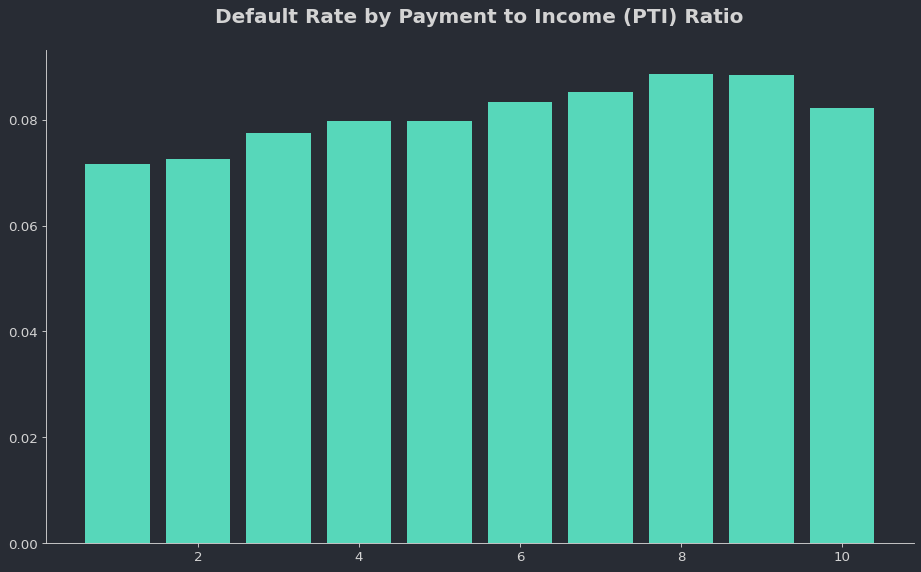

In [ ]:
col = 'payment_to_income_ratio'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Payment to Income (PTI) Ratio')

plt.show()

# TO DO:  add axes titles

People who get credit for more than the item they are buying that was that catalyst to applying for credit in the first place default more often

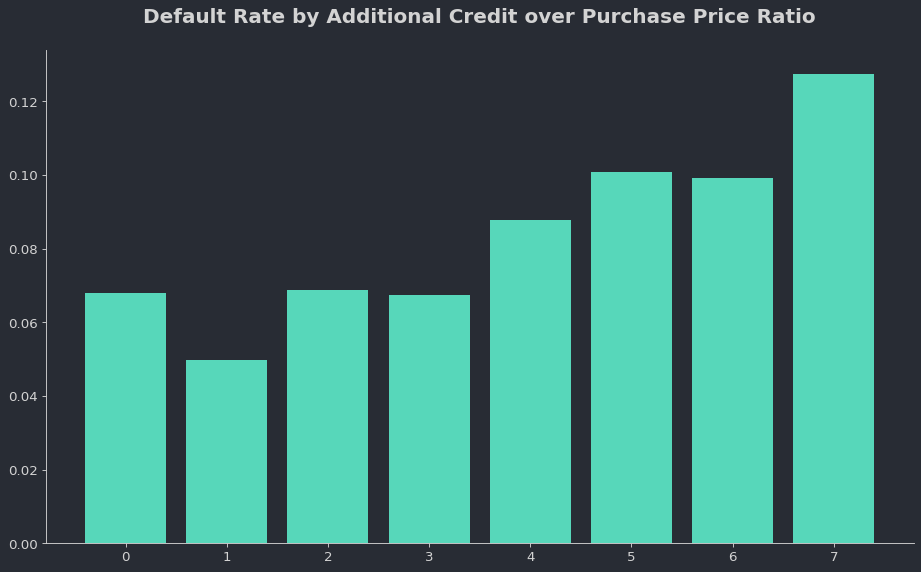

In [ ]:
col = 'additional_credit_pct_over_price'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp[bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Additional Credit over Purchase Price Ratio')

plt.show()

# TO DO:  add axes titles

## Credit Card Data

Credit card utilization rate is a very strong predictor of subsequent loans. This data is available for about ~30% of the population of the training data

## TODO: Attempt to get this for other customers via bureau data

In [ ]:
#grouping by each person "sk_id_curr"

cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'amt_balance':'sum','amt_credit_limit_actual':'sum'})

In [ ]:
cc_grp['avg_credit_utilization_rate'] = cc_grp['amt_balance'] / cc_grp['amt_credit_limit_actual']


In [ ]:
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')


In [ ]:
# eliminate any infinite values
cc_grp = cc_grp[~np.isinf(cc_grp['avg_credit_utilization_rate'])].copy()

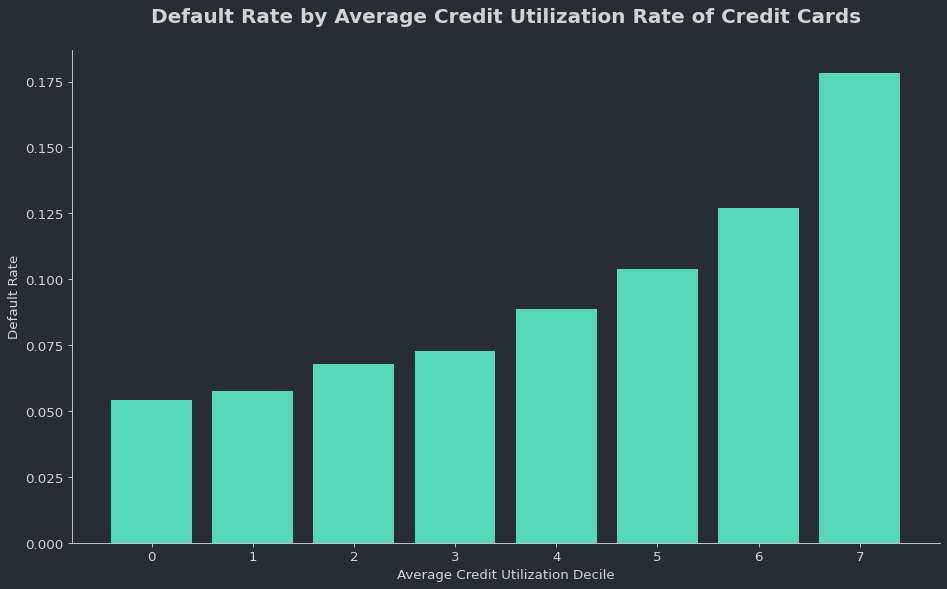

In [ ]:
col = 'avg_credit_utilization_rate'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Average Credit Utilization Rate of Credit Cards')
ax.set_xlabel('Average Credit Utilization Decile')
ax.set_ylabel('Default Rate')

plt.show()


In [ ]:
#merge findings into train and test datasets
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','avg_credit_utilization_rate']],how='left',on='sk_id_curr')
d['application_train_df']['no_previous_credit_card_history_ind'] = np.where(d['application_train_df']['avg_credit_utilization_rate'].isna(),1,0)
d['application_train_df']['avg_credit_utilization_rate'].fillna(d['application_train_df']['avg_credit_utilization_rate'].mean(),inplace=True)

In [ ]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','avg_credit_utilization_rate']],how='left',on='sk_id_curr')
d['application_test_df']['no_previous_credit_card_history_ind'] = np.where(d['application_test_df']['avg_credit_utilization_rate'].isna(),1,0)
d['application_test_df']['avg_credit_utilization_rate'].fillna(d['application_test_df']['avg_credit_utilization_rate'].mean(),inplace=True)

ATM Withdrawl rate is correlated with default rate

In [ ]:
d['credit_card_balance_df']['atm_withdrawal'] = np.where(d['credit_card_balance_df']['amt_drawings_atm_current'] > 0,1,0)
cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'atm_withdrawal':'sum','cnt_drawings_atm_current':'sum','months_balance':'count'})
cc_grp['pct_atm'] = cc_grp['atm_withdrawal'] / cc_grp['months_balance']
cc_grp['atm_per_month'] = cc_grp['cnt_drawings_atm_current'] / cc_grp['months_balance']
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')


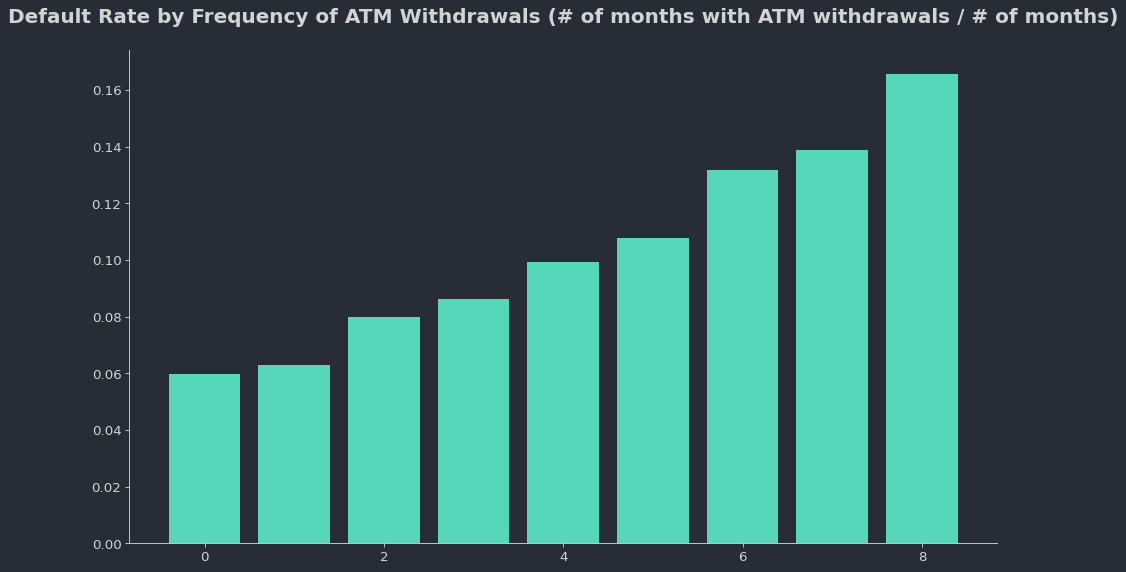

''

In [ ]:
col = 'pct_atm'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 15, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Frequency of ATM Withdrawals (# of months with ATM withdrawals / # of months)')

plt.show()

# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('ATM Withdrawal Frequency Decile')

;

In [ ]:
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','atm_per_month']],how='left',on='sk_id_curr')


In [ ]:
#No need for an additional dummy variable for no CC history
d['application_train_df'].loc[d['application_train_df']['atm_per_month'].isna(),'no_previous_credit_card_history_ind'].value_counts()

1    218986
Name: no_previous_credit_card_history_ind, dtype: int64

In [ ]:
d['application_train_df']['atm_per_month'].fillna(d['application_train_df']['atm_per_month'].mean(),inplace=True)

In [ ]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','atm_per_month']],how='left',on='sk_id_curr')

In [ ]:
d['application_test_df'].loc[d['application_test_df']['atm_per_month'].isna(),'no_previous_credit_card_history_ind'].value_counts()

1    32091
Name: no_previous_credit_card_history_ind, dtype: int64

In [ ]:
d['application_test_df']['atm_per_month'].fillna(d['application_test_df']['atm_per_month'].mean(),inplace=True)

Customers who pay off their balance each month have a strong correlation with not defaulting on subsequent loans.

In [ ]:
#doing 99% here for some cushion.. arbitrary
d['credit_card_balance_df']['had_balance'] = np.where(d['credit_card_balance_df']['amt_balance'] > 0,1,0)
d['credit_card_balance_df']['paid_off_balance'] = np.where(d['credit_card_balance_df']['amt_balance'] * 0.99 <  d['credit_card_balance_df']['amt_total_receivable'],1,0)
cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'had_balance':'sum','paid_off_balance':'sum'})
cc_grp['pct_full_payment'] = cc_grp['paid_off_balance'] / cc_grp['had_balance']
#max of 1 for what we're trying to do here
cc_grp.loc[cc_grp['pct_full_payment'] > 1,'pct_full_payment'] = 1
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')

In [ ]:
#People who never actually used their CC have low default rates, as if they paid off their CC 100% of the time. Filling these in as 100% will avoid having another dummy variable for this which would have huge overlap with the previous one
cc_grp.loc[cc_grp['pct_full_payment'].isna(),'target'].mean()

0.05537531337560832

In [ ]:
cc_grp['pct_full_payment'].fillna(1,inplace=True)

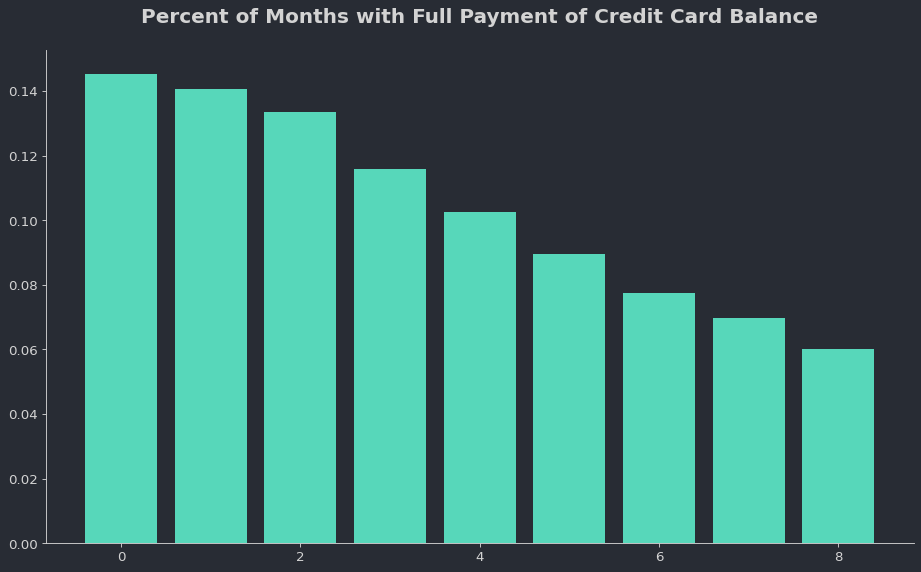

''

In [ ]:
col = 'pct_full_payment'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 15, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Percent of Months with Full Payment of Credit Card Balance')

plt.show()


ax.set_ylabel('Default Rate')
ax.set_xlabel('Percent of Months with Full Payment of Credit Card Balance Decile')
;

In [ ]:
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','pct_full_payment']],how='left',on='sk_id_curr')

In [ ]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','pct_full_payment']],how='left',on='sk_id_curr')

In [ ]:
d['application_train_df'].loc[d['application_train_df']['pct_full_payment'].isna(),'no_previous_credit_card_history_ind'].value_counts()

1    218986
Name: no_previous_credit_card_history_ind, dtype: int64

In [ ]:
d['application_test_df'].loc[d['application_test_df']['pct_full_payment'].isna(),'no_previous_credit_card_history_ind'].value_counts()

1    32091
Name: no_previous_credit_card_history_ind, dtype: int64

In [ ]:
d['application_train_df']['pct_full_payment'].fillna(d['application_train_df']['pct_full_payment'].mean(),inplace=True)
d['application_test_df']['pct_full_payment'].fillna(d['application_test_df']['pct_full_payment'].mean(),inplace=True)

The number of credit cards is not worth considering due to low sample of people with more than 1 credit card

In [ ]:
cc_grp = d['credit_card_balance_df'].groupby('sk_id_curr').agg({'sk_id_prev':'nunique'}).rename(columns = {'sk_id_prev':'n_credit_cards'})

In [ ]:
cc_grp['n_credit_cards'].value_counts()

1    102818
2       732
3         7
4         1
Name: n_credit_cards, dtype: int64

Percent of time the customer is past due does not have a clear correlation to future default rate and will be excluded

In [ ]:
# percent of time that they are pass due
d['credit_card_balance_df']['is_past_due_1'] = np.where(d['credit_card_balance_df']['sk_dpd'] > 0,1,0)
# d['credit_card_balance_df']['is_past_due_2'] = np.where(d['credit_card_balance_df']['sk_dpd_def'] > 0,1,0)
cc_grp = d['credit_card_balance_df'].groupby('sk_id_curr').agg({'is_past_due_1':'sum','months_balance':'count'})
cc_grp['past_due_pct_1'] = cc_grp['is_past_due_1'] / cc_grp['months_balance']
# cc_grp['past_due_pct_2'] = cc_grp['is_past_due_2'] / cc_grp['months_balance']
cc_grp['past_due_pct_1_bin'] = pd.cut(cc_grp['past_due_pct_1'],bins = [-0.01,0.0001,0.2,0.4,0.6,0.8,1.0],labels = [x for x in range(1,7)])
# cc_grp['past_due_pct_2_bin'] = pd.cut(cc_grp['past_due_pct_2'],bins = [-0.01,0.0001,0.2,0.4,0.6,0.8,1.0],labels = [x for x in range(1,7)])
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')

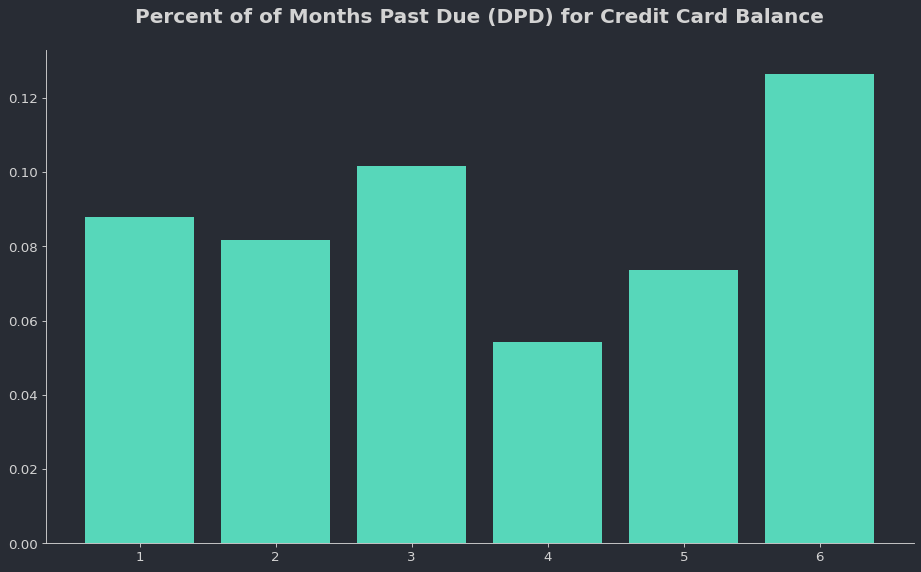

Text(0.5, 3.5555555555555483, 'Percent of Months Past Due (DPD) for Credit Card Balance Decile')

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = cc_grp.groupby('past_due_pct_1_bin').agg({'target':'mean','months_balance':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title("Percent of of Months Past Due (DPD) for Credit Card Balance")

plt.show()

# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('Percent of Months Past Due (DPD) for Credit Card Balance Decile')

# Previous Application Dataset

Next, we analyze the `previous_application_df` for features that might be useful in our modeling.

In [ ]:
d['application_train_df'][d['application_train_df']['sk_id_curr'] == 100006]

,sk_id_curr,target,code_gender,flag_own_realty,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,housing_pca_1,housing_pca_2,housing_pca_3,housing_pca_4,housing_pca_5,housing_pca_6,housing_pca_7,housing_pca_8,housing_pca_9,housing_pca_10,housing_pca_11,housing_pca_12,has_child,has_multiple_children,lives_alone,unknown_credit,changed_phone_day_of,null_ext_source_1,null_ext_source_3,obs_30_cnt_social_circle_log,def_30_cnt_social_circle_log,obs_60_cnt_social_circle_log,def_60_cnt_social_circle_log,name_contract_type_Cash loans,name_contract_type_Revolving loans,flag_own_car_N,flag_own_car_Y,name_income_type_Commercial associate,name_income_type_Other,name_income_type_Pensioner,name_income_type_State servant,name_income_type_Working,name_education_type_Higher education,name_education_type_Incomplete higher,name_education_type_Lower secondary,name_education_type_Secondary / secondary special,name_family_status_Civil marriage,...,name_housing_type_With parents,occupation_type_Accountants,occupation_type_Cleaning staff,occupation_type_Cooking staff,occupation_type_Core staff,occupation_type_Drivers,occupation_type_HR staff,occupation_type_High skill tech staff,occupation_type_IT staff,occupation_type_Laborers,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Unknown,occupation_type_Waiters/barmen staff,weekday_appr_process_start_FRIDAY,weekday_appr_process_start_MONDAY,weekday_appr_process_start_SATURDAY,weekday_appr_process_start_SUNDAY,weekday_appr_process_start_THURSDAY,weekday_appr_process_start_TUESDAY,weekday_appr_process_start_WEDNESDAY,hour_appr_process_start_afternoon,hour_appr_process_start_early-morning,hour_appr_process_start_morning,hour_appr_process_start_night,organization_type_Advertising,organization_type_Agriculture,organization_type_Bank,organization_type_Business Entity Type 1,organization_type_Business Entity Type 2,organization_type_Business Entity Type 3,organization_type_Cleaning,organization_type_Construction,organization_type_Culture,organization_type_Electricity,organization_type_Emergency,organization_type_Government,organization_type_Hotel,organization_type_Housing,organization_type_Industry: type 1,organization_type_Industry: type 10,organization_type_Industry: type 11,organization_type_Industry: type 12,organization_type_Industry: type 13,organization_type_Industry: type 2,organization_type_Industry: type 3,organization_type_Industry: type 4,organization_type_Industry: type 5,organization_type_Industry: type 6,organization_type_Industry: type 7,organization_type_Industry: type 8,organization_type_Industry: type 9,organization_type_Insurance,organization_type_Kindergarten,organization_type_Legal Services,organization_type_Medicine,organization_type_Military,orga

In [ ]:
d['previous_application_df'][d['previous_application_df']['sk_id_curr'] == 100006]

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
98162,2078043,100006,Cash loans,24246.00,675000.00,675000.0,NaN,675000.00,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Approved,-181,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,48.0,low_normal,Cash X-Sell: low,365243.0,-151.0,1259.0,-151.0,-143.0,0.0
617859,2827850,100006,Revolving loans,NaN,0.00,0.0,NaN,NaN,THURSDAY,15,Y,1,NaN,NaN,NaN,XAP,Canceled,-181,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
830967,2190416,100006,Consumer loans,29027.52,334917.00,267930.0,66987.00,334917.00,SUNDAY,15,Y,1,0.217830,NaN,NaN,XAP,Approved,-311,Cash through the bank,XAP,Family,Repeater,Audio/Video,POS,XNA,Country-wide,8025,Consumer electronics,12.0,high,POS household with interest,365243.0,-281.0,49.0,365243.0,365243.0,0.0
900957,1489396,100006,Revolving loans,13500.00,270000.00,270000.0,NaN,270000.00,THURSDAY,15,Y,1,NaN,NaN,NaN,XAP,Approved,-181,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
1131133,1020698,100006,Cash loans,39954.51,454500.00,481495.5,NaN,454500.00,SATURDAY,12,Y,1,NaN,NaN,NaN,XNA,Approved,-438,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,high,Cash X-Sell: high,NaN,NaN,NaN,NaN,NaN,NaN
1232752,1243599,100006,Cash loans,NaN,0.00,0.0,NaN,NaN,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-181,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1333657,2299329,100006,Consumer loans,2482.92,26912.34,24219.0,2693.34,26912.34,TUESDAY,15,Y,1,0.108994,NaN,NaN,XAP,Approved,-617,XNA,XAP,NaN,New,Construction Materials,POS,XNA,Stone,30,Construction,12.0,middle,POS industry with interest,365243.0,-545.0,-215.0,-425.0,-416.0,0.0
1595430,2545789,100006,Cash loans,NaN,0.00,0.0,NaN,NaN,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-181,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1607443,1697039,100006,Cash loans,32696.10,688500.00,906615.0,NaN,688500.00,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Refused,-181,Cash through the bank,LIMIT,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,48.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN


We engineered the following features for possible selection in our model:

* previous_rejections
* sum_previous_credit_requested
* sum_previous_credit_approved
* number_of_previous_applications

In [ ]:
#d['previous_application_df']['name_cash_loan_purpose'].unique()

In [ ]:
d['previous_application_df']['name_contract_status'].unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [ ]:
# encode the `name_contract_status` attribute

d['previous_application_df']['name_contract_status_encode'] = [ 1 if elem == 'Refused' else 0 for elem in d['previous_application_df']['name_contract_status'] ]
d['previous_application_df'].head(3)


,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval,name_contract_status_encode
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0


In [ ]:
previous_applications_enriched_df = d['previous_application_df'].groupby(['sk_id_curr']) \
                                                     .agg({
                                                           'name_contract_status_encode' : 'sum',
                                                            'amt_application' : 'sum',
                                                            'amt_credit' : 'sum',
                                                            'sk_id_prev' : 'count'
                                                      }) \
                                                      .rename(columns={'name_contract_status_encode' : 'previous_rejection',
                                                                       'amt_application' : 'sum_previous_credit_requested',
                                                                       'amt_credit' : 'sum_previous_credit_approved',
                                                                       'sk_id_prev' : 'number_of_previous_applications'
                                                      }) \
                                                      .reset_index()



# after grouping by sk_id_curr, now create an indicator for any previous rejection
previous_applications_enriched_df['previous_rejection'] = [ 1 if elem > 0 else 0 for elem in previous_applications_enriched_df['previous_rejection'] ]
previous_applications_enriched_df.head(5)

,sk_id_curr,previous_rejection,sum_previous_credit_requested,sum_previous_credit_approved,number_of_previous_applications
0,100001,0,24835.5,23787.0,1
1,100002,0,179055.0,179055.0,1
2,100003,0,1306309.5,1452573.0,3
3,100004,0,24282.0,20106.0,1
4,100005,0,44617.5,40153.5,2


Let's filter for only previous applications that were either `approved` or `refused`.

In [ ]:
app_states = ['Approved', 'Refused']

previous_application_subset = d['previous_application_df'][d['previous_application_df']['name_contract_status'].isin(app_states)]
previous_application_subset.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval,name_contract_status_encode
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
d['previous_application_df']['name_contract_status'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: name_contract_status, dtype: int64

In [ ]:
# TO DO:  we can join these back to application_train_df to get a better picture (speak to Paul and Milan about this, though)
# Paul Note: Unused offer should probably be grouped in with Approved. Refused has a large enough sample size that it might be worth considering as well

In [ ]:
previous_applications_enriched_df.loc[previous_applications_enriched_df['sum_previous_credit_requested'] == 0]

,sk_id_curr,previous_rejection,sum_previous_credit_requested,sum_previous_credit_approved,number_of_previous_applications
113,100120,0,0.0,0.0,3
347,100368,0,0.0,112500.0,4
825,100870,0,0.0,135000.0,1
1162,101216,0,0.0,112500.0,1
2109,102199,0,0.0,180000.0,1
...,...,...,...,...,...
337479,454839,0,0.0,67500.0,1
337480,454841,0,0.0,0.0,3
338605,455999,0,0.0,0.0,1
338780,456177,0,0.0,0.0,1


In [ ]:
#Convert these to a log scale
previous_applications_enriched_df['sum_previous_credit_requested'] = np.log(previous_applications_enriched_df['sum_previous_credit_requested'] + 1)
previous_applications_enriched_df['sum_previous_credit_approved'] = np.log(previous_applications_enriched_df['sum_previous_credit_approved'] + 1)


In [ ]:
# TESTING (IGNORE)
#d['previous_application_df']['down_payment_percentage'] = d['previous_application_df']['amt_down_payment'] / d['previous_application_df']['amt_goods_price']
#d['previous_application_df'].head(3)

In [ ]:
# TESTING (IGNORE)
#d['previous_application_df']['ratio_credit_received'] = d['previous_application_df']['amt_credit'] / d['previous_application_df']['amt_application']
#d['previous_application_df'].head(3)


In [ ]:
# join the previous application data to the training dataset
d['application_train_df'] = pd.merge(d['application_train_df'], previous_applications_enriched_df, on = 'sk_id_curr', how = 'left')
d['application_test_df'] = pd.merge(d['application_test_df'], previous_applications_enriched_df, on = 'sk_id_curr', how = 'left')

In [ ]:
#using intuion, we will fill nulls with 0 because if they have no previous applications, they should have 0 for all of these

d['application_train_df']['previous_rejection'].fillna(0,inplace=True)
d['application_train_df']['sum_previous_credit_requested'].fillna(0,inplace=True)
d['application_train_df']['sum_previous_credit_approved'].fillna(0,inplace=True)
d['application_train_df']['number_of_previous_applications'].fillna(0,inplace=True)

d['application_test_df']['previous_rejection'].fillna(0,inplace=True)
d['application_test_df']['sum_previous_credit_requested'].fillna(0,inplace=True)
d['application_test_df']['sum_previous_credit_approved'].fillna(0,inplace=True)
d['application_test_df']['number_of_previous_applications'].fillna(0,inplace=True)

In [ ]:
temp = d['application_train_df'][['target','sum_previous_credit_requested','sum_previous_credit_approved']].copy()
temp['sum_previous_credit_requested_bin'] = pd.qcut(temp['sum_previous_credit_requested'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['sum_previous_credit_approved_bin'] = pd.qcut(temp['sum_previous_credit_approved'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))

''

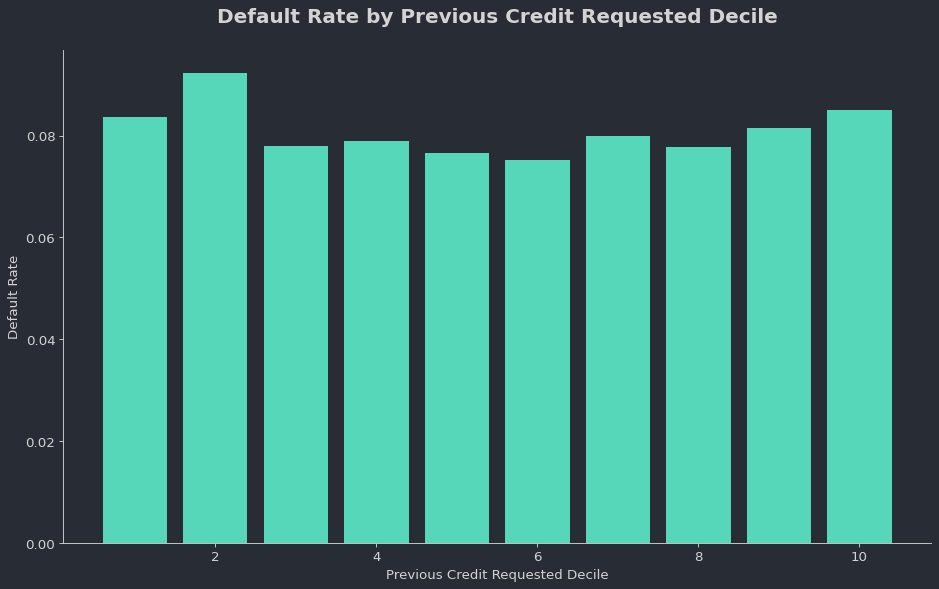

In [ ]:
# Are applicants who previously requested signficant credit more likely to default?  No!
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp_grp = temp.groupby('sum_previous_credit_requested_bin').agg({'target':'mean'})

ax.bar(temp_grp.index, temp_grp['target'])

ax.set_title("Default Rate by Previous Credit Requested Decile")


# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('Previous Credit Requested Decile')

;

Text(0.5, 0, 'Previous Credit Approved Decile')

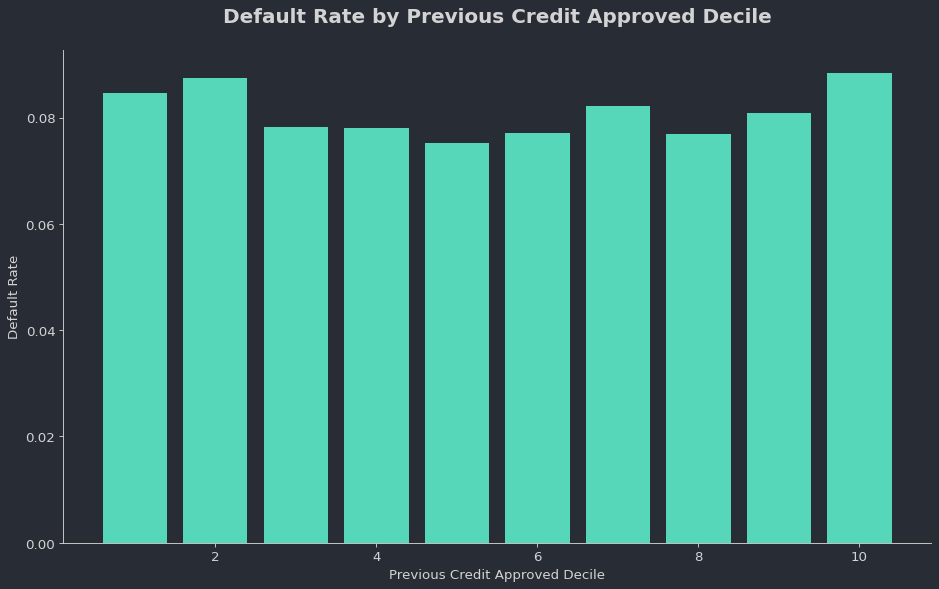

In [ ]:
# Are applicants who previously were approved for signficant credit more likely to default?  No!
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp_grp = temp.groupby('sum_previous_credit_approved_bin').agg({'target':'mean'})

ax.bar(temp_grp.index, temp_grp['target'])

ax.set_title("Default Rate by Previous Credit Approved Decile")


ax.set_ylabel('Default Rate')
ax.set_xlabel('Previous Credit Approved Decile')

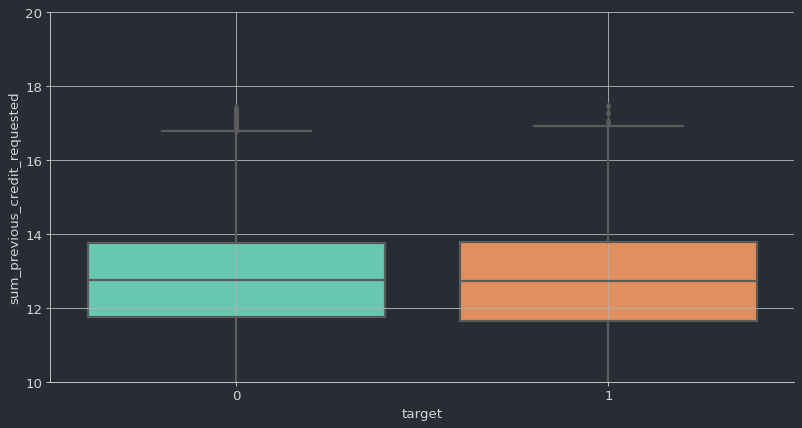

In [ ]:

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'sum_previous_credit_requested')
plt.grid()

plt.ylim(10,20)


plt.show()

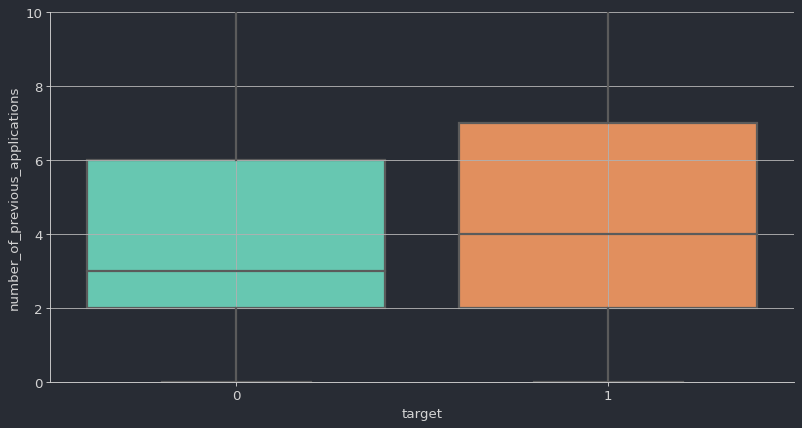

In [ ]:
# Is the number of previous applications correlated with default?  Possibly...

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'number_of_previous_applications')
plt.ylim(0,10)
plt.grid()

plt.show()

In [ ]:
#memory management b/c this was a copy
temp.drop(temp.index,inplace=True)
del temp

In [ ]:
# Are borrowers who have previously been rejected more likely to default? Yes!

previous_rejection_target_counts = d['application_train_df'].groupby(['previous_rejection', 'target']).size()

previous_rejection_target_counts_unstacked = previous_rejection_target_counts.unstack('target')

percentage_defaults_by_previous_rejection = previous_rejection_target_counts_unstacked.div(previous_rejection_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_previous_rejection)

target                      0          1
previous_rejection                      
0.0                 92.998791   7.001209
1.0                 89.671906  10.328094


## Results of Exploratory Data Analysis

Placeholder for results of our EDA...

*   List item
*   List item



#Feature Engineering

In [ ]:
pd.set_option('display.max_rows', 400)
d['application_train_df'].isna().sum()

sk_id_curr                                           0
target                                               0
code_gender                                          0
flag_own_realty                                      0
amt_income_total                                     0
amt_credit                                           0
amt_annuity                                          0
amt_goods_price                                      0
region_population_relative                           0
days_birth                                           0
days_employed                                        0
days_registration                                    0
days_id_publish                                      0
own_car_age                                          0
flag_mobil                                           0
flag_emp_phone                                       0
flag_work_phone                                      0
flag_cont_mobile                                     0
flag_phone

In [ ]:
d['application_test_df'].isna().sum()

sk_id_curr                                           0
code_gender                                          0
flag_own_realty                                      0
amt_income_total                                     0
amt_credit                                           0
amt_annuity                                          0
amt_goods_price                                      0
region_population_relative                           0
days_birth                                           0
days_employed                                        0
days_registration                                    0
days_id_publish                                      0
own_car_age                                          0
flag_mobil                                           0
flag_emp_phone                                       0
flag_work_phone                                      0
flag_cont_mobile                                     0
flag_phone                                           0
flag_email

In [ ]:
pd.set_option('display.max_rows', 50)

In [ ]:
d['application_train_df'].info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305834 entries, 0 to 305833
Data columns (total 213 columns):
 #    Column                                             Non-Null Count   Dtype  
---   ------                                             --------------   -----  
 0    sk_id_curr                                         305834 non-null  int64  
 1    target                                             305834 non-null  int64  
 2    code_gender                                        305834 non-null  int64  
 3    flag_own_realty                                    305834 non-null  int64  
 4    amt_income_total                                   305834 non-null  float64
 5    amt_credit                                         305834 non-null  float64
 6    amt_annuity                                        305834 non-null  float64
 7    amt_goods_price                                    305834 non-null  float64
 8    region_population_relative                         305834 non-

#Machine Learning Modeling

In this section, we build and train the following supervised machine learning models:

* logistic regression
* random forest
* gradient boosted trees
* neural networks

In [ ]:
# Create our X and y datasets

X = d['application_train_df'].drop('target', axis = 1)
X.head()

,sk_id_curr,code_gender,flag_own_realty,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,housing_pca_1,housing_pca_2,housing_pca_3,housing_pca_4,housing_pca_5,housing_pca_6,housing_pca_7,housing_pca_8,housing_pca_9,housing_pca_10,housing_pca_11,housing_pca_12,has_child,has_multiple_children,lives_alone,unknown_credit,changed_phone_day_of,null_ext_source_1,null_ext_source_3,obs_30_cnt_social_circle_log,def_30_cnt_social_circle_log,obs_60_cnt_social_circle_log,def_60_cnt_social_circle_log,name_contract_type_Cash loans,name_contract_type_Revolving loans,flag_own_car_N,flag_own_car_Y,name_income_type_Commercial associate,name_income_type_Other,name_income_type_Pensioner,name_income_type_State servant,name_income_type_Working,name_education_type_Higher education,name_education_type_Incomplete higher,name_education_type_Lower secondary,name_education_type_Secondary / secondary special,name_family_status_Civil marriage,name_family_status_Married,...,occupation_type_Core staff,occupation_type_Drivers,occupation_type_HR staff,occupation_type_High skill tech staff,occupation_type_IT staff,occupation_type_Laborers,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Unknown,occupation_type_Waiters/barmen staff,weekday_appr_process_start_FRIDAY,weekday_appr_process_start_MONDAY,weekday_appr_process_start_SATURDAY,weekday_appr_process_start_SUNDAY,weekday_appr_process_start_THURSDAY,weekday_appr_process_start_TUESDAY,weekday_appr_process_start_WEDNESDAY,hour_appr_process_start_afternoon,hour_appr_process_start_early-morning,hour_appr_process_start_morning,hour_appr_process_start_night,organization_type_Advertising,organization_type_Agriculture,organization_type_Bank,organization_type_Business Entity Type 1,organization_type_Business Entity Type 2,organization_type_Business Entity Type 3,organization_type_Cleaning,organization_type_Construction,organization_type_Culture,organization_type_Electricity,organization_type_Emergency,organization_type_Government,organization_type_Hotel,organization_type_Housing,organization_type_Industry: type 1,organization_type_Industry: type 10,organization_type_Industry: type 11,organization_type_Industry: type 12,organization_type_Industry: type 13,organization_type_Industry: type 2,organization_type_Industry: type 3,organization_type_Industry: type 4,organization_type_Industry: type 5,organization_type_Industry: type 6,organization_type_Industry: type 7,organization_type_Industry: type 8,organization_type_Industry: type 9,organization_type_Insurance,organization_type_Kindergarten,organization_type_Legal Services,organization_type_Medicine,organization_type_Military,organization_type_Mobile,organization_type_Other,organization_type_Police,organization_type_Postal,organ

In [ ]:
y = d['application_train_df']['target']
y.head()

0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

# Modeling TODOs:
- Which models should we be using scaled data, and which model should we be using the raw data?

## Logistic Regression

In [ ]:
random_state = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled_resampled, y_train_scaled_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train_scaled, y_train)
X_test_scaled_resampled, y_test_scaled_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test_scaled, y_test)

In [ ]:
# get these optimized parameters from Grid Search (see below)
optimized_C = 10
optimized_penalty = 'l2'

logistic_regression_model = LogisticRegression(max_iter = 10_000, C = optimized_C, penalty = optimized_penalty)
logistic_regression_model.fit(X_train_scaled_resampled, y_train_scaled_resampled)
#if not lr_model.converged_:
#  print('The model did not converge.')


In [ ]:
# make predictions from the test data
y_pred = logistic_regression_model.predict(X_test_scaled_resampled)


In [ ]:
accuracy = logistic_regression_model.score(X_test_scaled_resampled, y_test_scaled_resampled)
print(f'The accuracy is: {accuracy:.2%}')


In [ ]:
# get the confusion matrix

confusion_matrix(y_test_scaled_resampled, y_pred)


In [ ]:
# get the accuracy, precision, recall and F1 scores

accuracy = accuracy_score(y_test_scaled_resampled, y_pred)
precision = precision_score(y_test_scaled_resampled, y_pred)
recall = recall_score(y_test_scaled_resampled, y_pred)
f1 = f1_score(y_test_scaled_resampled, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')


In [ ]:
# plot the ROC curve

y_proba = logistic_regression_model.predict_proba(X_test_scaled_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_scaled_resampled, y_proba)
auc = roc_auc_score(y_test_scaled_resampled, y_proba)
print(auc)

In [ ]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Logistic Regression with PCA

In [ ]:
pca = PCA(n_components = X_train_scaled[0].size)
pca.fit(X_train_scaled)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.plot(cum_evr)
ax.set_xticks(np.arange(0, X_train_scaled[0].size, 5))
ax.set_xticklabels(np.arange(0, X_train_scaled[0].size, 5) + 1, rotation = 90)

ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Ratio')
ax.set_title('Cumulative Explained Ratio by Number of Principal Components')

#Vertical Line here at 11 really means 12 components
ax.axvline(168, linestyle = '--', color='green')

plt.show()

In [ ]:
"{:.2%}".format(cum_evr[168]) #note that 168 is the 169th component

In [ ]:
pca = PCA(n_components = 169)
pca.fit(X_train_scaled)

In [ ]:
X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

In [ ]:
#really no need to reassign y_train and y_test here b/c the seed is the same
X_train_PCA_resampled, y_train_PCA_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train_PCA, y_train)
X_test_PCA_resampled, y_test_PCA_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test_PCA, y_test)

In [ ]:
optimized_C = 10
optimized_penalty = 'l2'

logistic_regression_model = LogisticRegression(max_iter = 10_000, C = optimized_C, penalty = optimized_penalty)
logistic_regression_model.fit(X_train_PCA_resampled, y_train_PCA_resampled)

In [ ]:
y_pred = logistic_regression_model.predict(X_test_PCA_resampled)

In [ ]:
accuracy = logistic_regression_model.score(X_test_scaled_resampled, y_test_scaled_resampled)
print(f'The accuracy is: {accuracy:.2%}')

In [ ]:
# get the confusion matrix

confusion_matrix(y_test_scaled_resampled, y_pred)

In [ ]:
# get the accuracy, precision, recall and F1 scores

accuracy = accuracy_score(y_test_scaled_resampled, y_pred)
precision = precision_score(y_test_scaled_resampled, y_pred)
recall = recall_score(y_test_scaled_resampled, y_pred)
f1 = f1_score(y_test_scaled_resampled, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')

In [ ]:
# plot the ROC curve

y_proba = logistic_regression_model.predict_proba(X_test_scaled_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_scaled_resampled, y_proba)
auc = roc_auc_score(y_test_scaled_resampled, y_proba)
print(auc)

In [ ]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Grid Search

In [ ]:
# create a pipeline

pipeline = Pipeline([
#    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter = 1000))
])

In [ ]:
# define the hyperparameter grid

# regularization strength
C_vals = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid = {
#    'scaler__with_mean' : [True, False],
#    'scaler__with_std'  : [True, False],
    'classifier__C' : C_vals,
#    'classifier__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9],   # this is the mix between L1 and L2 regularization
    'classifier__penalty' : ['l1', 'l2']
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy')

In [ ]:
# fit the grid search to the data (takes about 15 minutes to run the grid search)
grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
best_model = grid_search.best_estimator_
best_model

In [ ]:
y_pred_optimzed = best_model.predict(X_test_scaled_resampled)

accuracy_optimized = best_model.score(X_test_scaled_resampled, y_test_scaled_resampled)
accuracy_optimized

Observations
* the grid search optimization improves accuracy *slightly*
* the AUC does not change

## Decision Trees

In [ ]:
# create the decision tree classifier
clf_tree = DecisionTreeClassifier(random_state = 42)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_tree, param_grid, scoring = 'accuracy')



In [ ]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

clf_tree.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_tree.predict(X_test_scaled_resampled)

In [ ]:
accuracy = clf_tree.score(X_test_scaled_resampled, y_test_scaled_resampled)
print(f'The accuracy is: {accuracy:.2%}')

In [ ]:
print(classification_report(y_test_scaled_resampled, y_pred))

In [ ]:
confusion_matrix(y_test_scaled_resampled, y_pred)


In [ ]:
# plot the ROC curve

y_proba = clf_tree.predict_proba(X_test_scaled_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_scaled_resampled, y_proba)
auc = roc_auc_score(y_test_scaled_resampled, y_proba)
print(auc)

In [ ]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Random Forest

In [ ]:
# create the random forest classifier
clf_random_forest = RandomForestClassifier(random_state = 42,max_depth = 10)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_random_forest, param_grid, scoring = 'accuracy')

In [ ]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

clf_random_forest.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_random_forest.predict(X_test_scaled_resampled)


In [ ]:
accuracy = clf_random_forest.score(X_test_scaled_resampled, y_test_scaled_resampled)
print(f'The accuracy is: {accuracy:.2%}')

In [ ]:
print(classification_report(y_test_scaled_resampled, y_pred))

In [ ]:
confusion_matrix(y_test_scaled_resampled, y_pred)

In [ ]:
# plot the ROC curve

y_proba = clf_random_forest.predict_proba(X_test_scaled_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_scaled_resampled, y_proba)
auc = roc_auc_score(y_test_scaled_resampled, y_proba)
print(auc)

In [ ]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Gradient Boosting

In [ ]:
# create the gradient boost classifier
clf_gradient_boost = GradientBoostingClassifier(random_state = 42)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_random_forest, param_grid, scoring = 'accuracy')

In [ ]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

clf_gradient_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_gradient_boost.predict(X_test_scaled_resampled)

In [ ]:
accuracy = clf_gradient_boost.score(X_test_scaled_resampled, y_test_scaled_resampled)
print(f'The accuracy is: {accuracy:.2%}')

In [ ]:
print(classification_report(y_test_scaled_resampled, y_pred))

In [ ]:
confusion_matrix(y_test_scaled_resampled, y_pred)

In [ ]:
# plot the ROC curve

y_proba = clf_gradient_boost.predict_proba(X_test_scaled_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_scaled_resampled, y_proba)
auc = roc_auc_score(y_test_scaled_resampled, y_proba)
print(auc)

In [ ]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## XG Boost

In [ ]:
# create the gradient boost classifier
clf_xg_boost = XGBClassifier(random_state = 42)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_random_forest, param_grid, scoring = 'accuracy')

In [ ]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

clf_xg_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_xg_boost.predict(X_test_scaled_resampled)

In [ ]:
accuracy = clf_xg_boost.score(X_test_scaled_resampled, y_test_scaled_resampled)
print(f'The accuracy is: {accuracy:.2%}')

In [ ]:
print(classification_report(y_test_scaled_resampled, y_pred))


In [ ]:
confusion_matrix(y_test_scaled_resampled, y_pred)


In [ ]:
# plot the ROC curve

y_proba = clf_xg_boost.predict_proba(X_test_scaled_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_scaled_resampled, y_proba)
auc = roc_auc_score(y_test_scaled_resampled, y_proba)
print(auc)


In [ ]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Challenges and Obstacles

TO DO

* grid search with 5-fold cross-validation takes a long time!

# Potential Next Steps / Future Direction

TO DO

could do AutoML